## 🧰 Colab Setup

In [ ]:
!pip install -q --upgrade plotly plotly-express

     |████████████████████████████████| 15.2 MB 21.4 MB/s 


In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.colheader_justify', 'left')
import numpy as np
import glob
import os
import math
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
import time


# For the plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import plotly
import plotly.express as px
import plotly.graph_objects as go

Notebook Color Scheme:


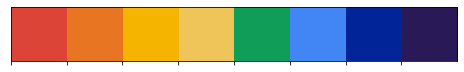

In [ ]:
nb_colors = ["#DB4437", "#E77522", "#F4B400", "#EFC459", "#0F9D58", "#4285F4", "#012599", "#2A1957"]
print("Notebook Color Scheme:")
sns.palplot(sns.color_palette(nb_colors))
plt.show()

# 📌 Neo4j Connection & Setup

In [ ]:
!pip install -q neo4j

     |████████████████████████████████| 90 kB 6.5 MB/s 


In [ ]:
from neo4j import GraphDatabase
import time

class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [ ]:
uri  = 'neo4j+s://9e4b2002.databases.neo4j.io:7687' 
pwd  = 'WTsQ7Q6zdjaeAKp0pfkMluyueEsibkYkBuCAPPXHPpw'
user = 'neo4j'
conn = Neo4jConnection(uri=uri, user=user , pwd=pwd)

### 🌪 Constraints

In [ ]:
conn.query("CREATE CONSTRAINT Players IF NOT EXISTS ON (n:Player) ASSERT n.id IS UNIQUE;")
conn.query("CREATE CONSTRAINT Matches IF NOT EXISTS ON (n:Match) ASSERT n.id IS UNIQUE;")
conn.query("CREATE CONSTRAINT Sets IF NOT EXISTS ON (n:Set) ASSERT n.id IS UNIQUE;")
conn.query("CREATE CONSTRAINT Tournaments IF NOT EXISTS ON (n:Tournament) ASSERT n.id IS UNIQUE;")

# 🎾 WTA Tennis Dataset

WTA: Women's Tennis Association

In [ ]:
!git clone https://github.com/JeffSackmann/tennis_wta/

Cloning into 'tennis_wta'...
remote: Enumerating objects: 2989, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 2989 (delta 152), reused 149 (delta 142), pack-reused 2830
Receiving objects: 100% (2989/2989), 133.16 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (2362/2362), done.
Checking out files: 100% (205/205), done.


In [ ]:
df_list = []
for i in range(2000,2023):
    temp = pd.read_csv(f'/content/tennis_wta/wta_matches_{i}.csv', index_col=None, header=0)
    df_list.append(temp)

df_wta = pd.concat(df_list, axis=0, ignore_index=True)
df_wta

tourney_id                tourney_name surface  draw_size tourney_level  tourney_date  match_num  winner_id winner_seed winner_entry              winner_name winner_hand  winner_ht winner_ioc  winner_age  loser_id loser_seed loser_entry          loser_name loser_hand  loser_ht loser_ioc  loser_age           score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  loser_rank_points
0                            2000-D001   Fed Cup G1 PO: JPN vs CHN    Hard          4             D      20000430          1     201419         NaN          NaN                    Na Li           R     172.00        CHN       18.17    201085        NaN         NaN      Shinobu Asagoe          R    170.00       JPN      23.84      7-6(6) 6-2        3    RR      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN       190.00              121.00      125.00             205.00
1                            2000-D001   Fed Cup G1 PO: JPN vs CHN    Hard          4             D      20000430          2     200085         NaN          NaN              Ai Sugiyama           R     163.00        JPN       24.82    200075        NaN         NaN        Jing Qian Yi          R    168.00       CHN      26.17         6-4 6-2        3    RR      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN        22.00             1230.00       96.00             319.00
2                            2000-D002   Fed Cup WG SF: USA vs BEL  Carpet          4             D      20001122          1     200652         NaN          NaN             Monica Seles           L     178.00        USA       26.97    200003        NaN         NaN       Justine Henin          R    167.00       BEL      18.48      7-6(1) 6-2        3    RR      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN         4.00             3255.00       48.00             661.00
3                            2000-D002   Fed Cup WG SF: USA vs BEL  Carpet          4             D      20001122          2     200128         NaN          NaN        Lindsay Davenport           R     189.00        USA       24.46    200079        NaN         NaN       Kim Clijsters          R    175.00       BEL      17.46  7-6(4) 4-6 6-3        3    RR      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN         2.00             5022.00       18.00            1398.00
4                            2000-D003   Fed Cup WG SF: CZE vs ESP  Carpet          4             D      20001121          1     200017         NaN          NaN  Arantxa Sanchez Vicario           R     168.00        ESP       28.93    201083        NaN         NaN       Daja Bedanova          R    171.00       CZE      17.71     5-7 6-4 6-3        3    RR      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN         9.00             2132.00       54.00             610.00
...                                ...                         ...     ...        ...           ...           ...        ...        ...         ...          ...                      ...         ...        ...        ...         ...       ...        ...         ...                 ...        ...       ...       ...        ...             ...      ...   ...      ...    ...   ...     ...      ...       ...       ...      ...        ...        ...    ...   ...     ...  

## 🗄️ WTA Roland Garros & US Open matches between 2000-2022

In [ ]:
df_wta_roland_us = df_wta[(df_wta.tourney_name.str.lower()=='us open') | (df_wta.tourney_name.str.lower()=='roland garros')].reset_index()
df_wta_roland_us

index              tourney_id   tourney_name surface  draw_size tourney_level  tourney_date  match_num  winner_id winner_seed winner_entry       winner_name winner_hand  winner_ht winner_ioc  winner_age  loser_id loser_seed loser_entry          loser_name loser_hand  loser_ht loser_ioc  loser_age           score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  loser_rank_points
0       726  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          1     200001        1.00          NaN    Martina Hingis           R     170.00        SUI       19.66    200037        NaN         NaN    Sabine Appelmans          L    168.00       BEL      28.10         6-0 6-4        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN         1.00             5982.00       24.00            1045.00
1       727  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          2     200018         NaN            Q         Julia Abe           R        NaN        GER       24.02    200666        NaN           Q      Marion Maruska          R    172.00       AUT      27.45     1-6 6-3 6-4        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN       156.00              165.00      159.00             159.00
2       728  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          3     200020         NaN          NaN      Lisa Raymond           R     165.00        USA       26.80    200764        NaN           Q        Elena Bovina          R    189.00       RUS      17.22         6-4 6-2        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN        27.00              965.00      207.00             110.00
3       729  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          4     200060         NaN          NaN   Tathiana Garbin           R     172.00        ITA       22.91    200657        NaN          SR       Radka Bobkova          R    172.00       CZE      27.29         6-1 6-2        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN        50.00              645.00         NaN                NaN
4       730  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          5     200044         NaN          NaN  Denisa Chladkova           R     174.00        CZE       21.30    200012        NaN         NaN        Jana Nejedly          R    175.00       CAN      25.97         6-3 6-4        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN        42.00              733.00       70.00             477.00
...     ...                     ...            ...     ...        ...           ...           ...        ...        ...         ...          ...               ...         ...        ...        ...         ...       ...        ...         ...                 ...        ...       ...       ...        ...             ...      ...   ...      ...    ...   ...     ...      ...       ...       ...      ...        ...        ...    ...   ...     ...      ...       ...       ...      ...        ...        ...          ...                 ...         ...                ...
5583  60097     

In [ ]:
df_wta_roland_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5588 entries, 0 to 5587
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               5588 non-null   int64  
 1   tourney_id          5588 non-null   object 
 2   tourney_name        5588 non-null   object 
 3   surface             5588 non-null   object 
 4   draw_size           5588 non-null   int64  
 5   tourney_level       5588 non-null   object 
 6   tourney_date        5588 non-null   int64  
 7   match_num           5588 non-null   int64  
 8   winner_id           5588 non-null   int64  
 9   winner_seed         3047 non-null   object 
 10  winner_entry        447 non-null    object 
 11  winner_name         5588 non-null   object 
 12  winner_hand         5588 non-null   object 
 13  winner_ht           5528 non-null   float64
 14  winner_ioc          5588 non-null   object 
 15  winner_age          5588 non-null   float64
 16  loser_

In [ ]:
df_wta_roland_us.tourney_name.unique()

array(['Roland Garros', 'US Open', 'Us Open'], dtype=object)

In [ ]:
df_wta_roland_us.tourney_name = df_wta_roland_us.tourney_name.replace('Us Open', 'US Open')
df_wta_roland_us.tourney_name.unique()

array(['Roland Garros', 'US Open'], dtype=object)

In [ ]:
df_wta_roland_us

index              tourney_id   tourney_name surface  draw_size tourney_level  tourney_date  match_num  winner_id winner_seed winner_entry       winner_name winner_hand  winner_ht winner_ioc  winner_age  loser_id loser_seed loser_entry          loser_name loser_hand  loser_ht loser_ioc  loser_age           score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  loser_rank_points
0       726  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          1     200001        1.00          NaN    Martina Hingis           R     170.00        SUI       19.66    200037        NaN         NaN    Sabine Appelmans          L    168.00       BEL      28.10         6-0 6-4        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN         1.00             5982.00       24.00            1045.00
1       727  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          2     200018         NaN            Q         Julia Abe           R        NaN        GER       24.02    200666        NaN           Q      Marion Maruska          R    172.00       AUT      27.45     1-6 6-3 6-4        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN       156.00              165.00      159.00             159.00
2       728  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          3     200020         NaN          NaN      Lisa Raymond           R     165.00        USA       26.80    200764        NaN           Q        Elena Bovina          R    189.00       RUS      17.22         6-4 6-2        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN        27.00              965.00      207.00             110.00
3       729  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          4     200060         NaN          NaN   Tathiana Garbin           R     172.00        ITA       22.91    200657        NaN          SR       Radka Bobkova          R    172.00       CZE      27.29         6-1 6-2        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN        50.00              645.00         NaN                NaN
4       730  2000-W-SL-FRA-01A-2000  Roland Garros    Clay        128             G      20000529          5     200044         NaN          NaN  Denisa Chladkova           R     174.00        CZE       21.30    200012        NaN         NaN        Jana Nejedly          R    175.00       CAN      25.97         6-3 6-4        3  R128      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN        NaN        NaN        42.00              733.00       70.00             477.00
...     ...                     ...            ...     ...        ...           ...           ...        ...        ...         ...          ...               ...         ...        ...        ...         ...       ...        ...         ...                 ...        ...       ...       ...        ...             ...      ...   ...      ...    ...   ...     ...      ...       ...       ...      ...        ...        ...    ...   ...     ...      ...       ...       ...      ...        ...        ...          ...                 ...         ...                ...
5583  60097     

<Figure size 864x1440 with 0 Axes>

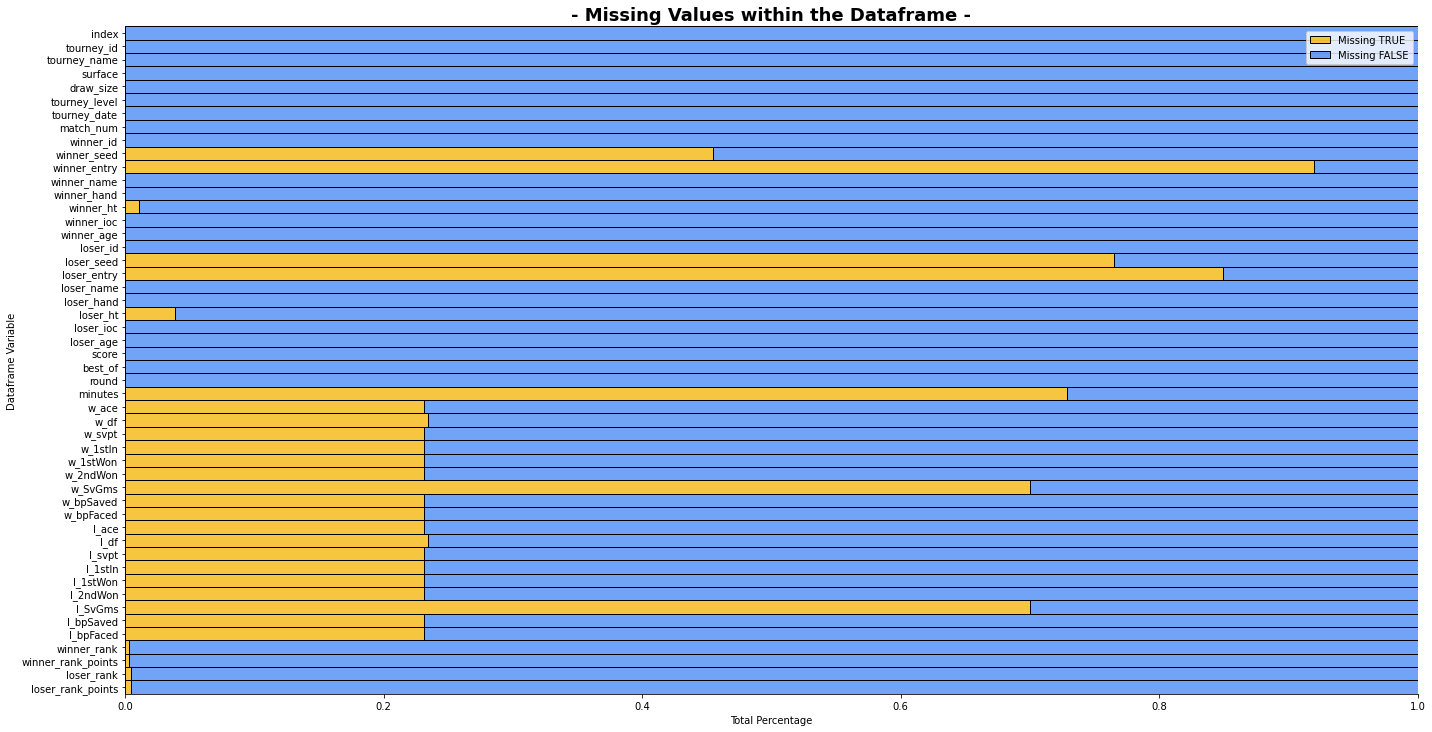

In [ ]:
# Show a dataframe of missing values
plt.figure(figsize=(12,20))

sns.displot(
    data=df_wta_roland_us.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    # Change aspect of the chart
    aspect=2,
    height=10,
    # Change colors
    palette=[nb_colors[5], nb_colors[2]], 
    legend=False)

plt.title("- Missing Values within the Dataframe -", size=18, weight="bold")
plt.xlabel("Total Percentage")
plt.ylabel("Dataframe Variable")
plt.legend(["Missing TRUE", "Missing FALSE"]);

<Figure size 288x288 with 0 Axes>

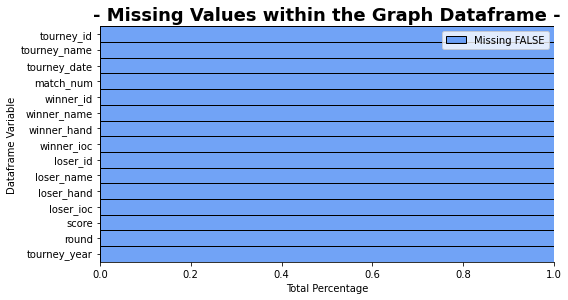

In [ ]:
df_wta_graph = df_wta_roland_us[['tourney_id', 'tourney_name', 'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_hand', 'winner_ioc', 'loser_id', 'loser_name', 'loser_hand', 'loser_ioc', 'score', 'round']]
df_wta_graph.tourney_date = pd.to_datetime(df_wta_graph.tourney_date, format='%Y%m%d')
df_wta_graph['tourney_year'] = df_wta_graph['tourney_date'].dt.year
# Show a dataframe of missing values
plt.figure(figsize=(4,4))

sns.displot(
    data=df_wta_graph.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    # Change aspect of the chart
    aspect=2,
    height=4,
    # Change colors
    palette=[nb_colors[5]], 
    legend=False)

plt.title("- Missing Values within the Graph Dataframe -", size=18, weight="bold")
plt.xlabel("Total Percentage")
plt.ylabel("Dataframe Variable")
plt.legend(["Missing FALSE"]);

In [ ]:
df_wta_graph.head()

tourney_id   tourney_name tourney_date  match_num  winner_id       winner_name winner_hand winner_ioc  loser_id        loser_name loser_hand loser_ioc        score round  tourney_year
0  2000-W-SL-FRA-01A-2000  Roland Garros   2000-05-29          1     200001    Martina Hingis           R        SUI    200037  Sabine Appelmans          L       BEL      6-0 6-4  R128          2000
1  2000-W-SL-FRA-01A-2000  Roland Garros   2000-05-29          2     200018         Julia Abe           R        GER    200666    Marion Maruska          R       AUT  1-6 6-3 6-4  R128          2000
2  2000-W-SL-FRA-01A-2000  Roland Garros   2000-05-29          3     200020      Lisa Raymond           R        USA    200764      Elena Bovina          R       RUS      6-4 6-2  R128          2000
3  2000-W-SL-FRA-01A-2000  Roland Garros   2000-05-29          4     200060   Tathiana Garbin           R        ITA    200657     Radka Bobkova          R       CZE      6-1 6-2  R128          2000
4  2000-W-SL-FRA-01A-2000  Roland Garros   2000-05-29          5     200044  Denisa Chladkova           R        CZE    200012      Jana Nejedly          R       CAN      6-3 6-4  R128          2000

In [ ]:
df_wta_graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5588 entries, 0 to 5587
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   tourney_id    5588 non-null   object        
 1   tourney_name  5588 non-null   object        
 2   tourney_date  5588 non-null   datetime64[ns]
 3   match_num     5588 non-null   int64         
 4   winner_id     5588 non-null   int64         
 5   winner_name   5588 non-null   object        
 6   winner_hand   5588 non-null   object        
 7   winner_ioc    5588 non-null   object        
 8   loser_id      5588 non-null   int64         
 9   loser_name    5588 non-null   object        
 10  loser_hand    5588 non-null   object        
 11  loser_ioc     5588 non-null   object        
 12  score         5588 non-null   object        
 13  round         5588 non-null   object        
 14  tourney_year  5588 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object

In [ ]:
df_wta_graph.to_csv('data.csv', index=False)

## 🔨 Creating the nodes and relationships of Tournaments, Matches, Players and Sets

In [ ]:
query="""
CALL apoc.periodic.iterate("
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/iamvarol/blogposts/main/medium/tennis/data.csv' AS row
WITH row, split(row.score, ' ') AS matchSets
WITH *, size(matchSets) AS setSize,
         row.tourney_name + '_' + row.tourney_year + '_' + 'WTA' AS tournament_id, 
         row.tourney_name + '_' + row.tourney_year + '_' + 'WTA' + '_' + row.match_num AS matchId
RETURN *
"
,
"
MERGE (t:Tournament {id: tournament_id})
ON CREATE SET t.name = row.tourney_name,
              t.year = toInteger(row.tourney_year),
              t.type = 'wta'

MERGE (m:Match {id: matchId})
ON CREATE SET m.round = row.round, 
              m.score = row.score,
              m.year = toInteger(row.tourney_year)

MERGE (p1:Player {id: row.winner_id})
ON CREATE SET p1.name = row.winner_name,
              p1.gender = 'Female',
              p1.hand = row.winner_hand,
              p1.ioc = row.winner_ioc

MERGE (p2:Player {id: row.loser_id})
ON CREATE SET p2.name = row.loser_name,
              p2.gender = 'Female',
              p2.hand = row.loser_hand,
              p2.ioc = row.loser_ioc
              
MERGE (p1)-[:MATCH_WINNER]->(m)
MERGE (p2)-[:MATCH_LOSER]->(m)
MERGE (m)-[:IN_TOURNAMENT]->(t)

WITH *
UNWIND range(0, setSize-1) AS setNumber
FOREACH (set IN matchSets |
    MERGE (s:Set {id: matchId + '_' + setNumber + 1})
    ON CREATE SET s.score = matchSets[setNumber],
                  s.number = setNumber +1
    MERGE (s)-[:IN_MATCH]->(m)
  )
"
,
{batchSize:100, parallel:false}
)
"""
conn.query(query)

[<Record batches=56 total=5588 timeTaken=2 committedOperations=5588 failedOperations=0 failedBatches=0 retries=0 errorMessages={} batch={'total': 56, 'committed': 56, 'failed': 0, 'errors': {}} operations={'total': 5588, 'committed': 5588, 'failed': 0, 'errors': {}} wasTerminated=False failedParams={} updateStatistics={'nodesDeleted': 0, 'labelsAdded': 19216, 'relationshipsCreated': 29656, 'nodesCreated': 19216, 'propertiesSet': 64664, 'relationshipsDeleted': 0, 'labelsRemoved': 0}>]

In [ ]:
query_string = '''
CALL db.labels() YIELD label
CALL apoc.cypher.run('MATCH (:`'+label+'`) RETURN count(*) as count',{}) YIELD value
RETURN label, value.count
'''
graph_nodes = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_nodes

label  value.count
0      Player          692
1       Match         5588
2         Set        12892
3  Tournament           44

In [ ]:
query_string = '''
CALL db.relationshipTypes() YIELD relationshipType as type
CALL apoc.cypher.run('MATCH ()-[:`'+type+'`]->() RETURN count(*) as count',{}) YIELD value
RETURN type, value.count
'''
graph_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_rels

type  value.count
0   MATCH_WINNER         5588
1    MATCH_LOSER         5588
2  IN_TOURNAMENT         5588
3       IN_MATCH        12892

In [ ]:
query_string = 'CALL apoc.meta.stats();'
graph_meta = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_meta

labelCount  relTypeCount  propertyKeyCount  nodeCount  relCount                                                          labels                                                                                                                                                                                                                                                                                                                                                                                                                                      relTypes                                                                          relTypesCount  \
0           4             4                10      19216     29656  {'Player': 692, 'Set': 12892, 'Tournament': 44, 'Match': 5588}  {'()-[:IN_TOURNAMENT]->(:Tournament)': 5588, '()-[:MATCH_LOSER]->()': 5588, '()-[:IN_MATCH]->()': 12892, '(:Player)-[:MATCH_WINNER]->()': 5588, '(:Set)-[:IN_MATCH]->()': 12892, '(:Match)-[:IN_TOURNAMENT]->()': 5588, '()-[:IN_MATCH]->(:Match)': 12892, '()-[:IN_TOURNAMENT]->()': 5588, '(:Player)-[:MATCH_LOSER]->()': 5588, '()-[:MATCH_WINNER]->(:Match)': 5588, '()-[:MATCH_LOSER]->(:Match)': 5588, '()-[:MATCH_WINNER]->()': 5588}  {'MATCH_LOSER': 5588, 'IN_TOURNAMENT': 5588, 'MATCH_WINNER': 5588, 'IN_MATCH': 12892}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     stats  
0  {'relTypeCount': 4, 'propertyKeyCount': 10, 'labelCount': 4, 'nodeCount': 19216, 'relCount': 29656, 'labels': {'Player': 692, 'Set': 12892, 'Tournament': 44, 'Match': 5588}, 'relTypes': {'()-[:IN_TOURNAMENT]->(:Tournament)': 5588, '()-[:MATCH_LOSER]->()': 5588, '()-[:IN_MATCH]->()': 12892, '(:Player)-[:MATCH_WINNER]->()': 5588, '(:Set)-[:IN_MATCH]->()': 12892, '(:Match)-[:IN_TOURNAMENT]->()': 5588, '()-[:IN_MATCH]->(:Match)': 12892, '()-[:IN_TOURNAMENT]->()': 5588, '(:Player)-[:MATCH_LOSER]->()': 5588, '()-[:MATCH_WINNER]->(:Match)': 5588, '()-[:MATCH_LOSER]->(:Match)': 5588, '()-[:MATCH_WINNER]->()': 5588}}

The image of loading with 50 batch size.
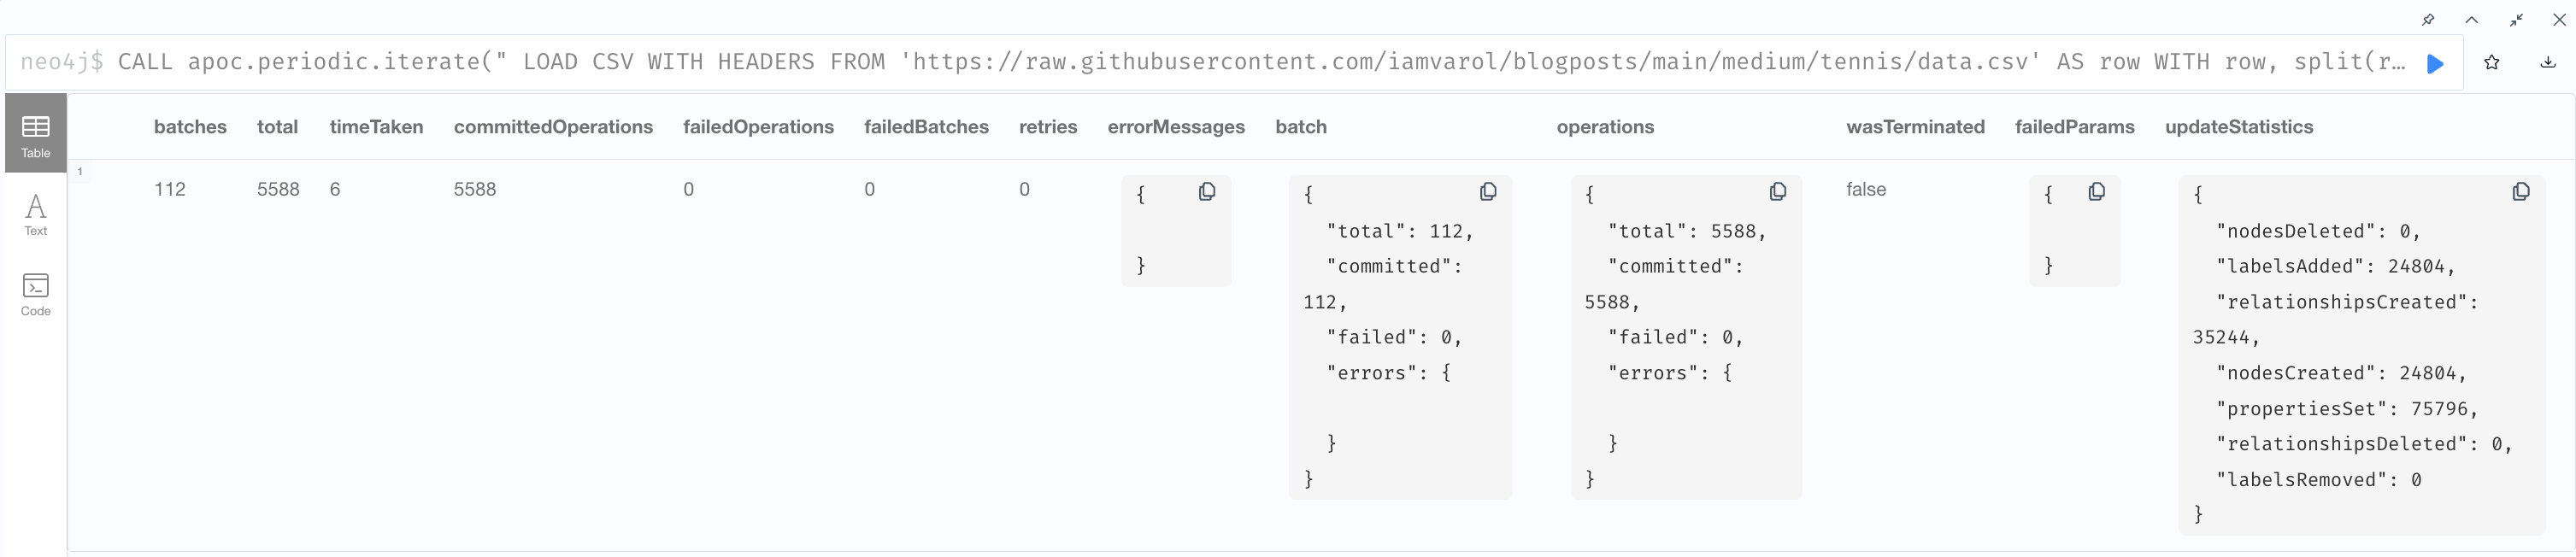

## 🔨 Sort "Tournament"s and "Match"es by dates and rounds & Create order-based relationship

In [ ]:
# sort tournaments by date and create order-relationship among them
query = """
MATCH (t:Tournament)
WHERE t.name = "Roland Garros" and t.type = "wta"
WITH t
ORDER BY t.year
WITH COLLECT(t) AS tournaments
CALL apoc.nodes.link(tournaments, "NEXT_TOURNAMENT");
"""
conn.query(query)

query = """
MATCH (t:Tournament)
WHERE t.name = "US Open"  and t.type = "wta"
WITH t
ORDER BY t.year
WITH COLLECT(t) AS tournaments
CALL apoc.nodes.link(tournaments, "NEXT_TOURNAMENT");
"""
conn.query(query)

[]

In [ ]:
# sort matches by rounds and create order-relationship among them
query = """
WITH ["R128", "R64", "R32", "R16", "QF", "SF", "F"] as roundList
WITH  apoc.map.fromLists(roundList, range(0, size(roundList)-1)) AS rounds
MATCH (t:Tournament)<-[:IN_TOURNAMENT]-(m:Match)<--(p)
WHERE t.name = "Roland Garros" and t.type = "wta"
WITH p, m, t
ORDER BY p, rounds[m.round]
WITH p, t, collect(m) AS matches
WHERE size(matches) > 1
CALL apoc.nodes.link(matches, "NEXT_MATCH");
"""
conn.query(query)

query = """
WITH ["R128", "R64", "R32", "R16", "QF", "SF", "F"] as roundList
WITH  apoc.map.fromLists(roundList, range(0, size(roundList)-1)) AS rounds
MATCH (t:Tournament)<-[:IN_TOURNAMENT]-(m:Match)<--(p)
WHERE t.name = "US Open" and t.type = "wta"
WITH p, m, t
ORDER BY p, rounds[m.round]
WITH p, t, collect(m) AS matches
WHERE size(matches) > 1
CALL apoc.nodes.link(matches, "NEXT_MATCH");
"""
conn.query(query)

[]

In [ ]:
query_string = '''
CALL db.labels() YIELD label
CALL apoc.cypher.run('MATCH (:`'+label+'`) RETURN count(*) as count',{}) YIELD value
RETURN label, value.count
'''
graph_nodes = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_nodes

label  value.count
0      Player          692
1       Match         5588
2         Set        12892
3  Tournament           44

In [ ]:
query_string = '''
CALL db.relationshipTypes() YIELD relationshipType as type
CALL apoc.cypher.run('MATCH ()-[:`'+type+'`]->() RETURN count(*) as count',{}) YIELD value
RETURN type, value.count
'''
graph_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_rels

type  value.count
0     MATCH_WINNER         5588
1      MATCH_LOSER         5588
2    IN_TOURNAMENT         5588
3         IN_MATCH        12892
4  NEXT_TOURNAMENT           42
5       NEXT_MATCH         5544

In [ ]:
query_string = 'CALL apoc.meta.stats();'
graph_meta = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_meta

labelCount  relTypeCount  propertyKeyCount  nodeCount  relCount                                                          labels                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     relTypes                                                                                                                     relTypesCount  \
0           4             6                10      19216     35242  {'Player': 692, 'Set': 12892, 'Tournament': 44, 'Match': 5588}  {'()-[:IN_TOURNAMENT]->(:Tournament)': 5588, '()-[:MATCH_LOSER]->()': 5588, '(:Match)-[:NEXT_MATCH]->()': 5544, '(:Set)-[:IN_MATCH]->()': 12892, '(:Match)-[:IN_TOURNAMENT]->()': 5588, '()-[:IN_MATCH]->(:Match)': 12892, '(:Player)-[:MATCH_LOSER]->()': 5588, '()-[:MATCH_WINNER]->(:Match)': 5588, '()-[:NEXT_MATCH]->()': 5544, '()-[:NEXT_MATCH]->(:Match)': 5544, '()-[:IN_MATCH]->()': 12892, '(:Player)-[:MATCH_WINNER]->()': 5588, '(:Tournament)-[:NEXT_TOURNAMENT]->()': 42, '()-[:IN_TOURNAMENT]->()': 5588, '()-[:NEXT_TOURNAMENT]->(:Tournament)': 42, '()-[:NEXT_TOURNAMENT]->()': 42, '()-[:MATCH_LOSER]->(:Match)': 5588, '()-[:MATCH_WINNER]->()': 5588}  {'MATCH_LOSER': 5588, 'IN_TOURNAMENT': 5588, 'NEXT_MATCH': 5544, 'NEXT_TOURNAMENT': 42, 'MATCH_WINNER': 5588, 'IN_MATCH': 12892}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    stats  
0  {'relTypeCount': 6, 'propertyKeyCount': 10, 'labelCount': 4, 'nodeCount': 19216, 'relCount': 35242, 'labels': {'Player': 692, 'Set': 12892, 'Tournament': 44, 'Match': 5588}, 'relTypes': {'()-[:IN_TOURNAMENT]->(:Tournament)': 5588, '()-[:MATCH_LOSER]->()': 5588, '(:Match)-[:NEXT_MATCH]->()': 5544, '(:Set)-[:IN_MATCH]->()': 12892, '(:Match)-[:IN_TOURNAMENT]->()': 5588, '()-[:IN_MATCH]->(:Match)': 12892, '(:Player)-[:MATCH_LOSER]->()': 5588, '()-[:MATCH_WINNER]->(:Match)': 5588, '()-[:NEXT_MATCH]->()': 5544, '()-[:NEXT_MATCH]->(:Match)': 5544, '()-[:IN_MATCH]->()': 12892, '(:Player)-[:MATCH_WINNER]->()': 5588, '(:Tournament)-[:NEXT_TOURNAMENT]->()': 42, '()-[:IN_TOURNAMENT]->()': 5588, '()-[:NEXT_TOURNAMENT]->(:Tournament)': 42, '()-[:NEXT_TOURNAMENT]->()': 42, '()-[:MATCH_LOSER]->(:Match)': 5588, '()-[:MATCH_WINNER]->()': 5588}}

# 🎾 ATP Tennis Dataset
ATP: Association of Tennis Professionals (Men's Professionals)

In [ ]:
!git clone https://github.com/JeffSackmann/tennis_atp

Cloning into 'tennis_atp'...
remote: Enumerating objects: 2392, done.
remote: Total 2392 (delta 0), reused 0 (delta 0), pack-reused 2392
Receiving objects: 100% (2392/2392), 242.99 MiB | 23.44 MiB/s, done.
Resolving deltas: 100% (1784/1784), done.
Checking out files: 100% (174/174), done.


In [ ]:
df_list = []
for i in range(2000,2023):
    temp = pd.read_csv(f'/content/tennis_atp/atp_matches_{i}.csv', index_col=None, header=0)
    df_list.append(temp)

df_atp = pd.concat(df_list, axis=0, ignore_index=True)
df_atp

tourney_id                  tourney_name surface  draw_size tourney_level  tourney_date  match_num  winner_id winner_seed winner_entry          winner_name winner_hand  winner_ht winner_ioc  winner_age  loser_id loser_seed loser_entry           loser_name loser_hand  loser_ht loser_ioc  loser_age            score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  loser_rank_points
0                              2000-301                      Auckland    Hard         32             A      20000110          1     103163        1.00          NaN           Tommy Haas           R     188.00        GER       21.77    101543        NaN         NaN         Jeff Tarango          L    180.00       USA      31.14      7-5 4-6 7-5        3   R32   108.00  18.00  4.00   96.00    49.00     39.00     28.00    17.00       3.00       5.00   7.00  8.00  106.00    55.00     39.00     29.00    17.00       4.00       7.00        11.00             1612.00       63.00             595.00
1                              2000-301                      Auckland    Hard         32             A      20000110          2     102607         NaN            Q        Juan Balcells           R     190.00        ESP       24.56    102644        NaN         NaN     Franco Squillari          L    183.00       ARG      24.39          7-5 7-5        3   R32    85.00   5.00  3.00   76.00    52.00     39.00     13.00    12.00       5.00       6.00   5.00 10.00   74.00    32.00     25.00     18.00    12.00       3.00       6.00       211.00              157.00       49.00             723.00
2                              2000-301                      Auckland    Hard         32             A      20000110          3     103252         NaN          NaN       Alberto Martin           R     175.00        ESP       21.39    102238        NaN         NaN  Alberto Berasategui          R    173.00       ESP      26.54          6-3 6-1        3   R32    56.00   0.00  0.00   55.00    35.00     25.00     12.00     8.00       1.00       1.00   0.00  6.00   56.00    33.00     20.00      7.00     8.00       7.00      11.00        48.00              726.00       59.00             649.00
3                              2000-301                      Auckland    Hard         32             A      20000110          4     103507        7.00          NaN  Juan Carlos Ferrero           R     183.00        ESP       19.91    103819        NaN         NaN        Roger Federer          R    185.00       SUI      18.42          6-4 6-4        3   R32    68.00   5.00  1.00   53.00    28.00     26.00     15.00    10.00       0.00       0.00  11.00  2.00   70.00    43.00     29.00     14.00    10.00       6.00       8.00        45.00              768.00       61.00             616.00
4                              2000-301                      Auckland    Hard         32             A      20000110          5     102103         NaN            Q         Michael Sell           R     180.00        USA       27.38    102765       4.00         NaN       Nicolas Escude          R    185.00       FRA      23.77   0-6 7-6(7) 6-1        3   R32   115.00   1.00  2.00   98.00    66.00     39.00     14.00    13.00       6.00      11.00   8.00  8.00   92.00    46.00     34.00     18.00    12.00       5.00       9.00       167.00              219.00       34.00             873.00
...                                 ...                           ...     ...        ...           ...           ...        ...        ...         ...          ...                  ...         ...        ...        ...         ...       ...        ...         ...                  ...        ...       ...       ...        ...              ...      ...   ...      ...    ...   ...     ...      ...       ...       ...      ...        ...        ...    ...   ...    

## 🗄️ WTA Roland Garros & US Open matches between 2000-2022

In [ ]:
df_atp_roland_us = df_atp[(df_atp.tourney_name.str.lower()=='us open') | (df_atp.tourney_name.str.lower()=='roland garros')].reset_index()
df_atp_roland_us

index tourney_id   tourney_name surface  draw_size tourney_level  tourney_date  match_num  winner_id winner_seed winner_entry            winner_name winner_hand  winner_ht winner_ioc  winner_age  loser_id loser_seed loser_entry               loser_name loser_hand  loser_ht loser_ioc  loser_age                   score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  loser_rank_points
0      2130   2000-520  Roland Garros    Clay        128             G      20000529          1     101736        1.00          NaN           Andre Agassi           R     180.00        USA       30.08    102179        NaN          WC            Antony Dupuis          R    185.00       FRA      27.26          7-6(7) 6-3 6-4        5  R128   132.00   8.00  3.00   99.00    67.00     49.00     19.00    15.00       2.00       4.00   9.00  6.00  100.00    52.00     38.00     22.00    16.00       9.00      13.00         1.00             5085.00      116.00             355.00
1      2131   2000-520  Roland Garros    Clay        128             G      20000529          2     102344         NaN          NaN           Karol Kucera           R     188.00        SVK       26.24    103202        NaN           Q            Oscar Serrano          R    173.00       ESP      22.01             6-1 6-2 6-1        5  R128    75.00  11.00  4.00   63.00    38.00     27.00     13.00    11.00       4.00       6.00   0.00  1.00   66.00    50.00     13.00      9.00    11.00      14.00      23.00        40.00              845.00      219.00             158.00
2      2132   2000-520  Roland Garros    Clay        128             G      20000529          3     103181         NaN          NaN             Jiri Vanek           R     185.00        CZE       22.10    102238        NaN         NaN      Alberto Berasategui          R    173.00       ESP      26.92  6-1 6-1 6-7(5) 5-7 6-1        5  R128   187.00   9.00  5.00  162.00    94.00     66.00     34.00    22.00       7.00      13.00   1.00  8.00  175.00   120.00     65.00     15.00    23.00      12.00      25.00        88.00              463.00       83.00             494.00
3      2133   2000-520  Roland Garros    Clay        128             G      20000529          4     102644         NaN          NaN       Franco Squillari           L     183.00        ARG       24.77    102880        NaN         NaN           Alexander Popp          R    201.00       GER      23.56         3-6 6-3 6-2 6-0        5  R128   117.00   2.00  4.00  100.00    56.00     37.00     25.00    16.00       4.00       7.00   2.00  4.00   86.00    50.00     27.00     17.00    16.00       9.00      17.00        45.00              802.00      110.00             376.00
4      2134   2000-520  Roland Garros    Clay        128             G      20000529          5     103454         NaN          NaN          Nicolas Massu           R     183.00        CHI       20.64    102831        NaN           Q              Jacobo Diaz          R    173.00       ESP      23.88             6-4 6-3 6-3        5  R128   130.00   5.00  1.00   89.00    45.00     30.00     23.00    14.00       6.00       9.00   2.00  5.00   89.00    60.00     36.00     10.00    14.00       5.00      12.00        75.00              579.00      130.00             310.00
...     ...        ...            ...     ...        ...           ...           ...        ...        ...         ...          ...                    ...         ...        ...        ...         ...       ...        ...         ...                      ...        ...       ...       ...        ...                     ...      ...   ...      ...    ...   ...     ...      ...       ...       ...      ...        ...        ...    ...   ...     ...      ...       ...       ...      ...        ...        ...          ...                 ...         ... 

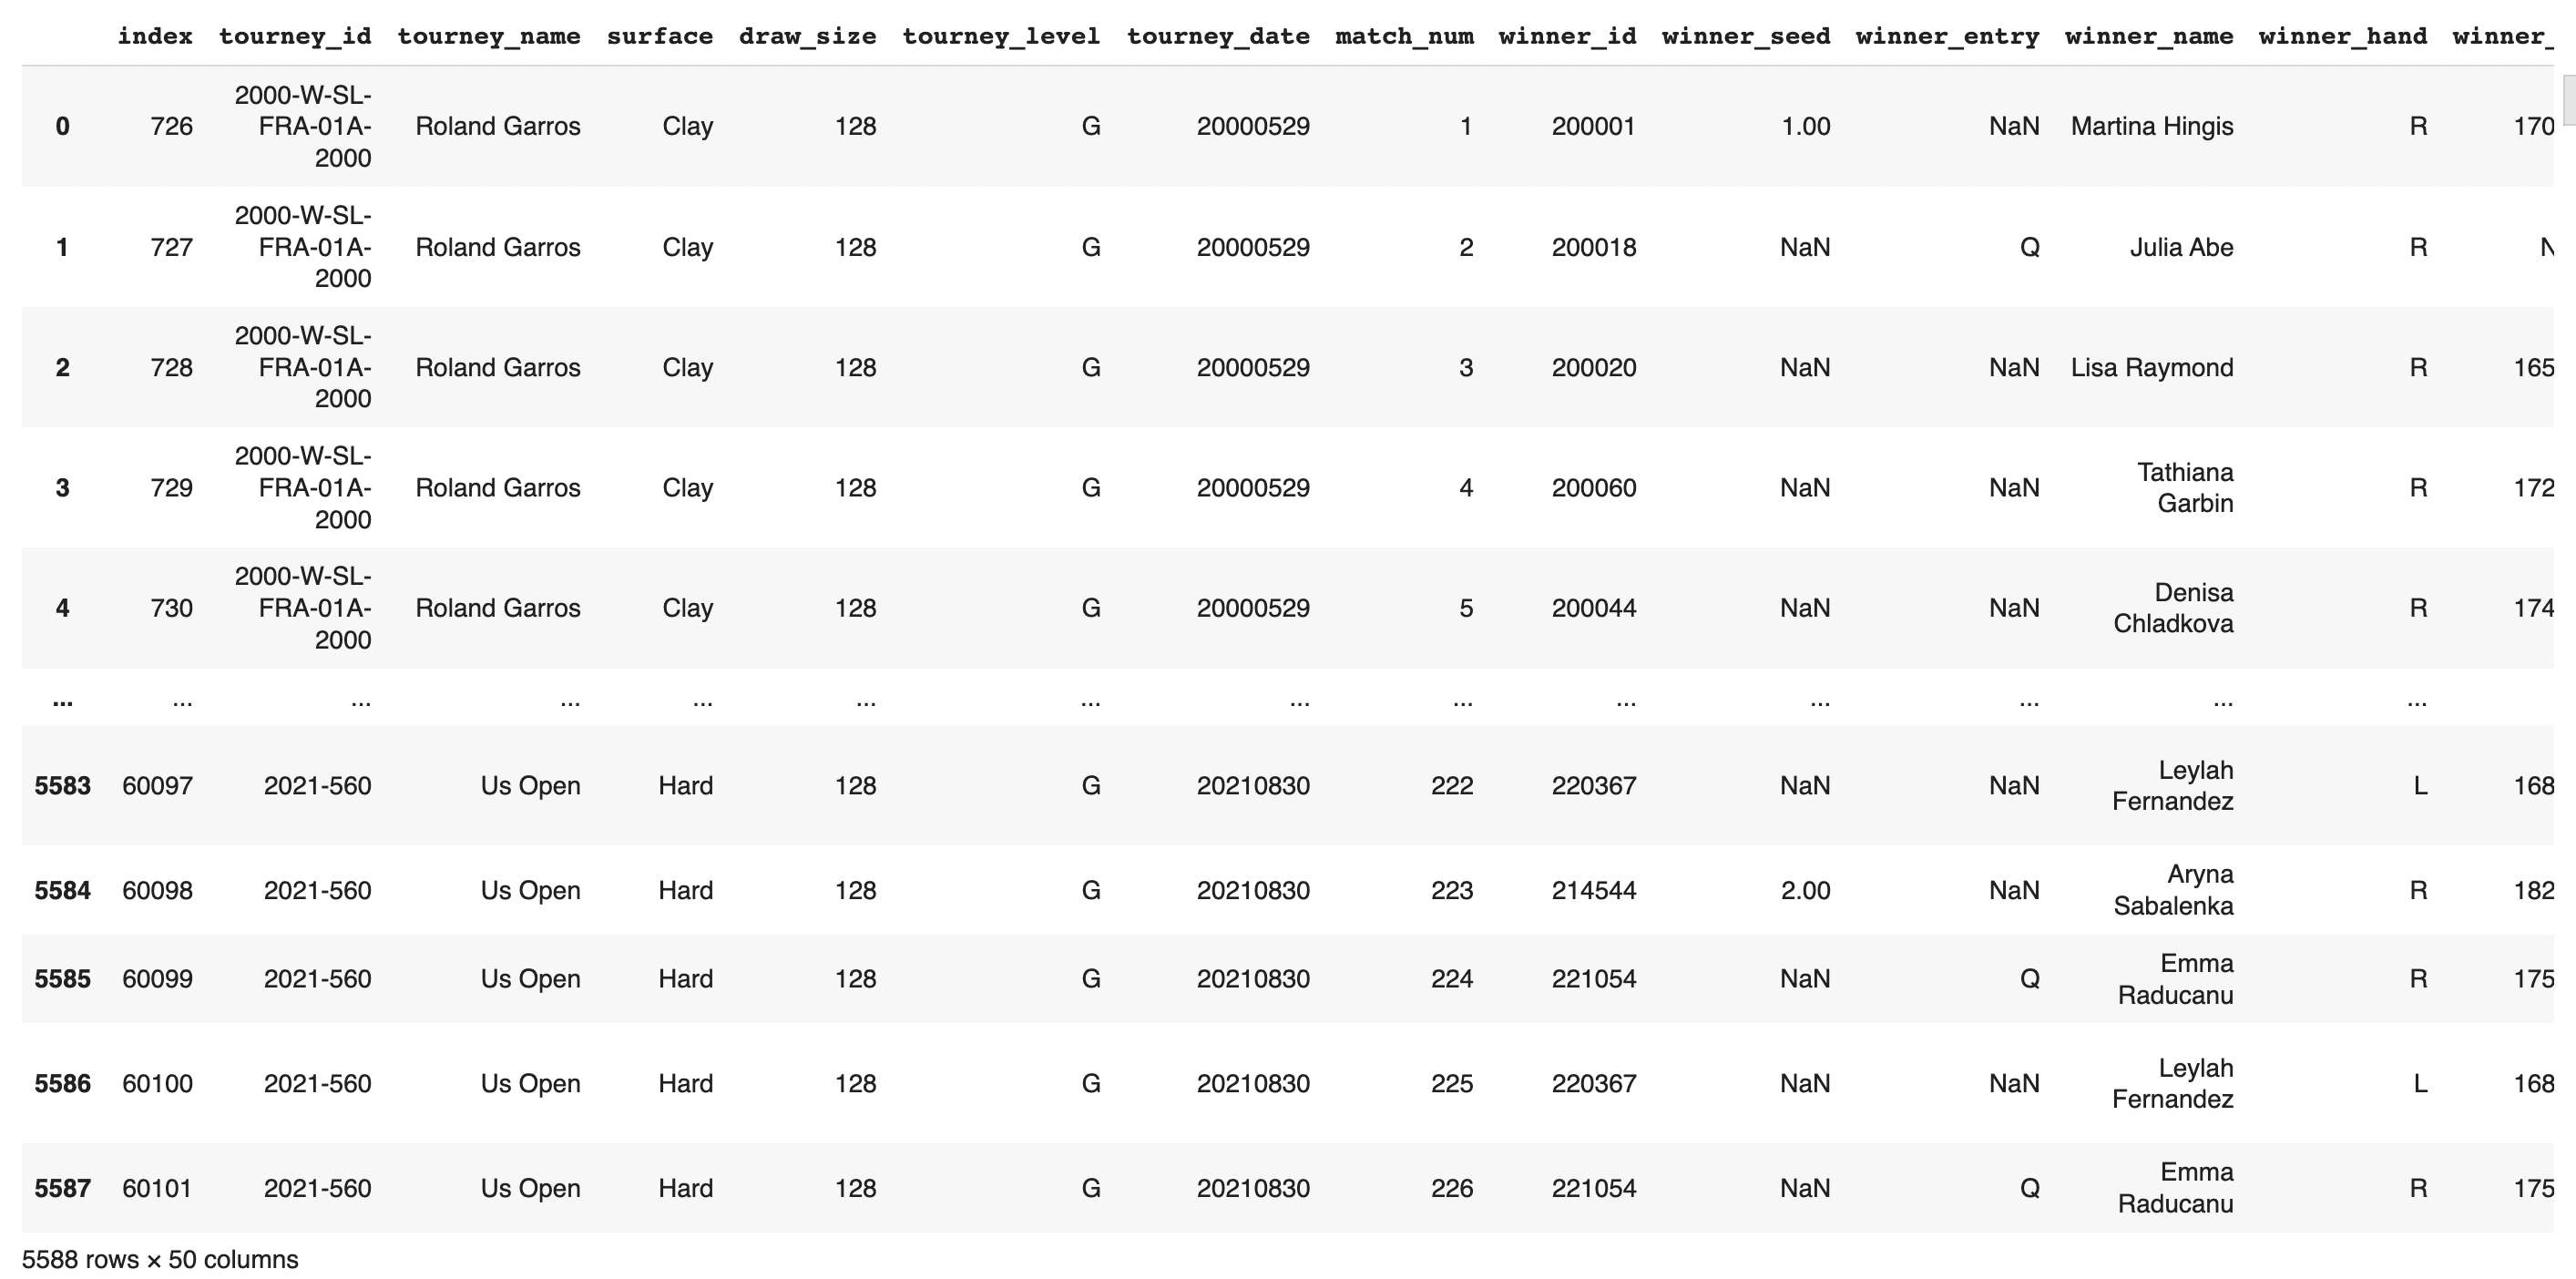

In [ ]:
df_atp_roland_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5588 entries, 0 to 5587
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               5588 non-null   int64  
 1   tourney_id          5588 non-null   object 
 2   tourney_name        5588 non-null   object 
 3   surface             5588 non-null   object 
 4   draw_size           5588 non-null   int64  
 5   tourney_level       5588 non-null   object 
 6   tourney_date        5588 non-null   int64  
 7   match_num           5588 non-null   int64  
 8   winner_id           5588 non-null   int64  
 9   winner_seed         3064 non-null   object 
 10  winner_entry        539 non-null    object 
 11  winner_name         5588 non-null   object 
 12  winner_hand         5588 non-null   object 
 13  winner_ht           5490 non-null   float64
 14  winner_ioc          5588 non-null   object 
 15  winner_age          5588 non-null   float64
 16  loser_

In [ ]:
df_atp_roland_us.tourney_name.unique()

array(['Roland Garros', 'US Open', 'Us Open'], dtype=object)

In [ ]:
df_atp_roland_us.tourney_name = df_atp_roland_us.tourney_name.replace('Us Open', 'US Open')
df_atp_roland_us.tourney_name.unique()

array(['Roland Garros', 'US Open'], dtype=object)

In [ ]:
df_atp_roland_us

index tourney_id   tourney_name surface  draw_size tourney_level  tourney_date  match_num  winner_id winner_seed winner_entry            winner_name winner_hand  winner_ht winner_ioc  winner_age  loser_id loser_seed loser_entry               loser_name loser_hand  loser_ht loser_ioc  loser_age                   score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  loser_rank_points
0      2130   2000-520  Roland Garros    Clay        128             G      20000529          1     101736        1.00          NaN           Andre Agassi           R     180.00        USA       30.08    102179        NaN          WC            Antony Dupuis          R    185.00       FRA      27.26          7-6(7) 6-3 6-4        5  R128   132.00   8.00  3.00   99.00    67.00     49.00     19.00    15.00       2.00       4.00   9.00  6.00  100.00    52.00     38.00     22.00    16.00       9.00      13.00         1.00             5085.00      116.00             355.00
1      2131   2000-520  Roland Garros    Clay        128             G      20000529          2     102344         NaN          NaN           Karol Kucera           R     188.00        SVK       26.24    103202        NaN           Q            Oscar Serrano          R    173.00       ESP      22.01             6-1 6-2 6-1        5  R128    75.00  11.00  4.00   63.00    38.00     27.00     13.00    11.00       4.00       6.00   0.00  1.00   66.00    50.00     13.00      9.00    11.00      14.00      23.00        40.00              845.00      219.00             158.00
2      2132   2000-520  Roland Garros    Clay        128             G      20000529          3     103181         NaN          NaN             Jiri Vanek           R     185.00        CZE       22.10    102238        NaN         NaN      Alberto Berasategui          R    173.00       ESP      26.92  6-1 6-1 6-7(5) 5-7 6-1        5  R128   187.00   9.00  5.00  162.00    94.00     66.00     34.00    22.00       7.00      13.00   1.00  8.00  175.00   120.00     65.00     15.00    23.00      12.00      25.00        88.00              463.00       83.00             494.00
3      2133   2000-520  Roland Garros    Clay        128             G      20000529          4     102644         NaN          NaN       Franco Squillari           L     183.00        ARG       24.77    102880        NaN         NaN           Alexander Popp          R    201.00       GER      23.56         3-6 6-3 6-2 6-0        5  R128   117.00   2.00  4.00  100.00    56.00     37.00     25.00    16.00       4.00       7.00   2.00  4.00   86.00    50.00     27.00     17.00    16.00       9.00      17.00        45.00              802.00      110.00             376.00
4      2134   2000-520  Roland Garros    Clay        128             G      20000529          5     103454         NaN          NaN          Nicolas Massu           R     183.00        CHI       20.64    102831        NaN           Q              Jacobo Diaz          R    173.00       ESP      23.88             6-4 6-3 6-3        5  R128   130.00   5.00  1.00   89.00    45.00     30.00     23.00    14.00       6.00       9.00   2.00  5.00   89.00    60.00     36.00     10.00    14.00       5.00      12.00        75.00              579.00      130.00             310.00
...     ...        ...            ...     ...        ...           ...           ...        ...        ...         ...          ...                    ...         ...        ...        ...         ...       ...        ...         ...                      ...        ...       ...       ...        ...                     ...      ...   ...      ...    ...   ...     ...      ...       ...       ...      ...        ...        ...    ...   ...     ...      ...       ...       ...      ...        ...        ...          ...                 ...         ... 

<Figure size 864x1440 with 0 Axes>

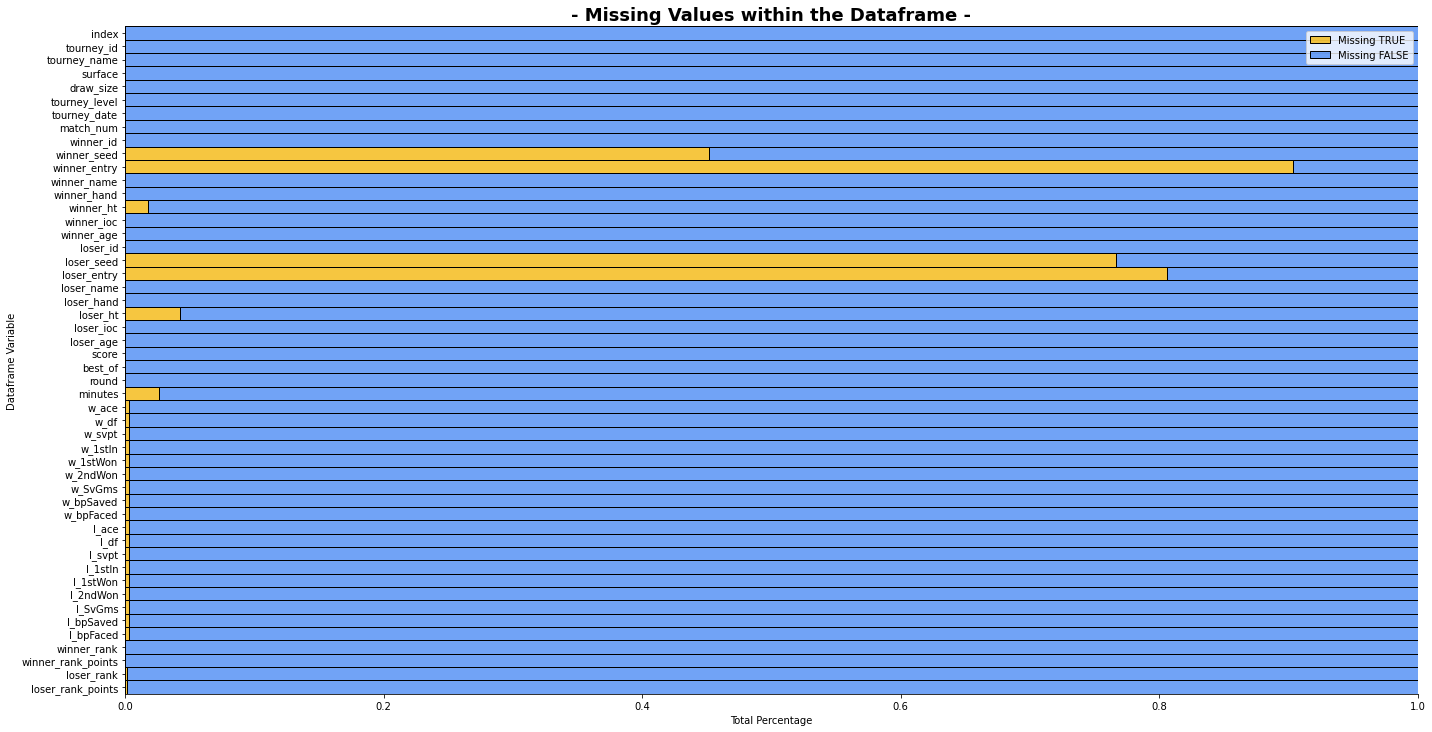

In [ ]:
# Show a dataframe of missing values
plt.figure(figsize=(12,20))

sns.displot(
    data=df_atp_roland_us.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    # Change aspect of the chart
    aspect=2,
    height=10,
    # Change colors
    palette=[nb_colors[5], nb_colors[2]], 
    legend=False)

plt.title("- Missing Values within the Dataframe -", size=18, weight="bold")
plt.xlabel("Total Percentage")
plt.ylabel("Dataframe Variable")
plt.legend(["Missing TRUE", "Missing FALSE"]);

<Figure size 288x288 with 0 Axes>

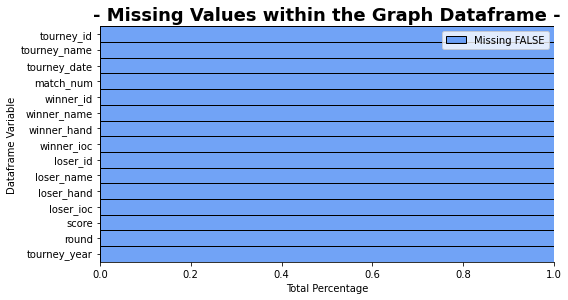

In [ ]:
df_atp_graph = df_atp_roland_us[['tourney_id', 'tourney_name', 'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_hand', 'winner_ioc', 'loser_id', 'loser_name', 'loser_hand', 'loser_ioc', 'score', 'round']]
df_atp_graph.tourney_date = pd.to_datetime(df_atp_graph.tourney_date, format='%Y%m%d')
df_atp_graph['tourney_year'] = df_atp_graph['tourney_date'].dt.year
# Show a dataframe of missing values
plt.figure(figsize=(4,4))

sns.displot(
    data=df_atp_graph.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    # Change aspect of the chart
    aspect=2,
    height=4,
    # Change colors
    palette=[nb_colors[5]], 
    legend=False)

plt.title("- Missing Values within the Graph Dataframe -", size=18, weight="bold")
plt.xlabel("Total Percentage")
plt.ylabel("Dataframe Variable")
plt.legend(["Missing FALSE"]);

In [ ]:
df_atp_graph.head()

tourney_id   tourney_name tourney_date  match_num  winner_id       winner_name winner_hand winner_ioc  loser_id           loser_name loser_hand loser_ioc                   score round  tourney_year
0   2000-520  Roland Garros   2000-05-29          1     101736      Andre Agassi           R        USA    102179        Antony Dupuis          R       FRA          7-6(7) 6-3 6-4  R128          2000
1   2000-520  Roland Garros   2000-05-29          2     102344      Karol Kucera           R        SVK    103202        Oscar Serrano          R       ESP             6-1 6-2 6-1  R128          2000
2   2000-520  Roland Garros   2000-05-29          3     103181        Jiri Vanek           R        CZE    102238  Alberto Berasategui          R       ESP  6-1 6-1 6-7(5) 5-7 6-1  R128          2000
3   2000-520  Roland Garros   2000-05-29          4     102644  Franco Squillari           L        ARG    102880       Alexander Popp          R       GER         3-6 6-3 6-2 6-0  R128          2000
4   2000-520  Roland Garros   2000-05-29          5     103454     Nicolas Massu           R        CHI    102831          Jacobo Diaz          R       ESP             6-4 6-3 6-3  R128          2000

In [ ]:
df_atp_graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5588 entries, 0 to 5587
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   tourney_id    5588 non-null   object        
 1   tourney_name  5588 non-null   object        
 2   tourney_date  5588 non-null   datetime64[ns]
 3   match_num     5588 non-null   int64         
 4   winner_id     5588 non-null   int64         
 5   winner_name   5588 non-null   object        
 6   winner_hand   5588 non-null   object        
 7   winner_ioc    5588 non-null   object        
 8   loser_id      5588 non-null   int64         
 9   loser_name    5588 non-null   object        
 10  loser_hand    5588 non-null   object        
 11  loser_ioc     5588 non-null   object        
 12  score         5588 non-null   object        
 13  round         5588 non-null   object        
 14  tourney_year  5588 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object

In [ ]:
df_atp_graph.to_csv('data_atp.csv', index=False)

## 🔨 Creating the nodes and relationships of Tournaments, Matches, Players and Sets

In [ ]:
query="""
CALL apoc.periodic.iterate("
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/iamvarol/blogposts/main/medium/tennis/data_atp.csv' AS row
WITH row, split(row.score, ' ') AS matchSets
WITH *, size(matchSets) AS setSize,
         row.tourney_name + '_' + row.tourney_year + '_' + 'ATP' AS tournament_id, 
         row.tourney_name + '_' + row.tourney_year + '_' + 'ATP' + '_' + row.match_num AS matchId
RETURN *
"
,
"
MERGE (t:Tournament {id: tournament_id})
ON CREATE SET t.name = row.tourney_name,
              t.year = toInteger(row.tourney_year),
              t.type = 'atp'

MERGE (m:Match {id: matchId})
ON CREATE SET m.round = row.round, 
              m.score = row.score,
              m.year = toInteger(row.tourney_year)

MERGE (p1:Player {id: row.winner_id})
ON CREATE SET p1.name = row.winner_name,
              p1.gender = 'Male',
              p1.hand = row.winner_hand,
              p1.ioc = row.winner_ioc

MERGE (p2:Player {id: row.loser_id})
ON CREATE SET p2.name = row.loser_name,
              p2.gender = 'Male',
              p2.hand = row.loser_hand,
              p2.ioc = row.loser_ioc
              
MERGE (p1)-[:MATCH_WINNER]->(m)
MERGE (p2)-[:MATCH_LOSER]->(m)
MERGE (m)-[:IN_TOURNAMENT]->(t)

WITH *
UNWIND range(0, setSize-1) AS setNumber
FOREACH (set IN matchSets |
    MERGE (s:Set {id: matchId + '_' + setNumber + 1})
    ON CREATE SET s.score = matchSets[setNumber],
                  s.number = setNumber +1
    MERGE (s)-[:IN_MATCH]->(m)
  )
"
,
{batchSize:100, parallel:false}
)
"""
conn.query(query)

[<Record batches=56 total=5588 timeTaken=4 committedOperations=5588 failedOperations=0 failedBatches=0 retries=0 errorMessages={} batch={'total': 56, 'committed': 56, 'failed': 0, 'errors': {}} operations={'total': 5588, 'committed': 5588, 'failed': 0, 'errors': {}} wasTerminated=False failedParams={} updateStatistics={'nodesDeleted': 0, 'labelsAdded': 26903, 'relationshipsCreated': 37329, 'nodesCreated': 26903, 'propertiesSet': 87753, 'relationshipsDeleted': 0, 'labelsRemoved': 0}>]

In [ ]:
query_string = '''
CALL db.labels() YIELD label
CALL apoc.cypher.run('MATCH (:`'+label+'`) RETURN count(*) as count',{}) YIELD value
RETURN label, value.count
'''
graph_nodes = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_nodes

label  value.count
0      Player         1398
1       Match        11176
2         Set        33457
3  Tournament           88

In [ ]:
query_string = '''
CALL db.relationshipTypes() YIELD relationshipType as type
CALL apoc.cypher.run('MATCH ()-[:`'+type+'`]->() RETURN count(*) as count',{}) YIELD value
RETURN type, value.count
'''
graph_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_rels

type  value.count
0     MATCH_WINNER        11176
1      MATCH_LOSER        11176
2    IN_TOURNAMENT        11176
3         IN_MATCH        33457
4  NEXT_TOURNAMENT           42
5       NEXT_MATCH         5544

In [ ]:
query_string = 'CALL apoc.meta.stats();'
graph_meta = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_meta

labelCount  relTypeCount  propertyKeyCount  nodeCount  relCount                                                            labels                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              relTypes                                                                                                                        relTypesCount  \
0           4             6                10      46119     72571  {'Player': 1398, 'Set': 33457, 'Tournament': 88, 'Match': 11176}  {'()-[:IN_TOURNAMENT]->(:Tournament)': 11176, '()-[:MATCH_LOSER]->()': 11176, '(:Match)-[:NEXT_MATCH]->()': 5544, '(:Set)-[:IN_MATCH]->()': 33457, '(:Match)-[:IN_TOURNAMENT]->()': 11176, '()-[:IN_MATCH]->(:Match)': 33457, '(:Player)-[:MATCH_LOSER]->()': 11176, '()-[:MATCH_WINNER]->(:Match)': 11176, '()-[:NEXT_MATCH]->()': 5544, '()-[:NEXT_MATCH]->(:Match)': 5544, '()-[:IN_MATCH]->()': 33457, '(:Player)-[:MATCH_WINNER]->()': 11176, '(:Tournament)-[:NEXT_TOURNAMENT]->()': 42, '()-[:IN_TOURNAMENT]->()': 11176, '()-[:NEXT_TOURNAMENT]->(:Tournament)': 42, '()-[:NEXT_TOURNAMENT]->()': 42, '()-[:MATCH_LOSER]->(:Match)': 11176, '()-[:MATCH_WINNER]->()': 11176}  {'MATCH_LOSER': 11176, 'IN_TOURNAMENT': 11176, 'NEXT_MATCH': 5544, 'NEXT_TOURNAMENT': 42, 'MATCH_WINNER': 11176, 'IN_MATCH': 33457}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               stats  
0  {'relTypeCount': 6, 'propertyKeyCount': 10, 'labelCount': 4, 'nodeCount': 46119, 'relCount': 72571, 'labels': {'Player': 1398, 'Set': 33457, 'Tournament': 88, 'Match': 11176}, 'relTypes': {'()-[:IN_TOURNAMENT]->(:Tournament)': 11176, '()-[:MATCH_LOSER]->()': 11176, '(:Match)-[:NEXT_MATCH]->()': 5544, '(:Set)-[:IN_MATCH]->()': 33457, '(:Match)-[:IN_TOURNAMENT]->()': 11176, '()-[:IN_MATCH]->(:Match)': 33457, '(:Player)-[:MATCH_LOSER]->()': 11176, '()-[:MATCH_WINNER]->(:Match)': 11176, '()-[:NEXT_MATCH]->()': 5544, '()-[:NEXT_MATCH]->(:Match)': 5544, '()-[:IN_MATCH]->()': 33457, '(:Player)-[:MATCH_WINNER]->()': 11176, '(:Tournament)-[:NEXT_TOURNAMENT]->()': 42, '()-[:IN_TOURNAMENT]->()': 11176, '()-[:NEXT_TOURNAMENT]->(:Tournament)': 42, '()-[:NEXT_TOURNAMENT]->()': 42, '()-[:MATCH_LOSER]->(:Match)': 11176, '()-[:MATCH_WINNER]->()': 11176}}

## 🔨 Sort "Tournament"s and "Match"es by dates and rounds & Create order-based relationship

In [ ]:
# sort tournaments by date and create order-relationship among them
query = """
MATCH (t:Tournament)
WHERE t.name = "Roland Garros" and t.type = "atp"
WITH t
ORDER BY t.year
WITH COLLECT(t) AS tournaments
CALL apoc.nodes.link(tournaments, "NEXT_TOURNAMENT");
"""
conn.query(query)

query = """
MATCH (t:Tournament)
WHERE t.name = "US Open"  and t.type = "atp"
WITH t
ORDER BY t.year
WITH COLLECT(t) AS tournaments
CALL apoc.nodes.link(tournaments, "NEXT_TOURNAMENT");
"""
conn.query(query)

[]

In [ ]:
# sort matches by rounds and create order-relationship among them
query = """
WITH ["R128", "R64", "R32", "R16", "QF", "SF", "F"] as roundList
WITH  apoc.map.fromLists(roundList, range(0, size(roundList)-1)) AS rounds
MATCH (t:Tournament)<-[:IN_TOURNAMENT]-(m:Match)<--(p)
WHERE t.name = "Roland Garros" and t.type = "atp"
WITH p, m, t
ORDER BY p, rounds[m.round]
WITH p, t, collect(m) AS matches
WHERE size(matches) > 1
CALL apoc.nodes.link(matches, "NEXT_MATCH");
"""
conn.query(query)

query = """
WITH ["R128", "R64", "R32", "R16", "QF", "SF", "F"] as roundList
WITH  apoc.map.fromLists(roundList, range(0, size(roundList)-1)) AS rounds
MATCH (t:Tournament)<-[:IN_TOURNAMENT]-(m:Match)<--(p)
WHERE t.name = "US Open" and t.type = "atp"
WITH p, m, t
ORDER BY p, rounds[m.round]
WITH p, t, collect(m) AS matches
WHERE size(matches) > 1
CALL apoc.nodes.link(matches, "NEXT_MATCH");
"""
conn.query(query)

[]

In [ ]:
query_string = '''
CALL db.labels() YIELD label
CALL apoc.cypher.run('MATCH (:`'+label+'`) RETURN count(*) as count',{}) YIELD value
RETURN label, value.count
'''
graph_nodes = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_nodes

label  value.count
0      Player         1398
1       Match        11176
2         Set        33457
3  Tournament           88

In [ ]:
query_string = '''
CALL db.relationshipTypes() YIELD relationshipType as type
CALL apoc.cypher.run('MATCH ()-[:`'+type+'`]->() RETURN count(*) as count',{}) YIELD value
RETURN type, value.count
'''
graph_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_rels

type  value.count
0     MATCH_WINNER        11176
1      MATCH_LOSER        11176
2    IN_TOURNAMENT        11176
3         IN_MATCH        33457
4  NEXT_TOURNAMENT           84
5       NEXT_MATCH        11088

In [ ]:
query_string = 'CALL apoc.meta.stats();'
graph_meta = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
graph_meta

labelCount  relTypeCount  propertyKeyCount  nodeCount  relCount                                                            labels                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 relTypes                                                                                                                         relTypesCount  \
0           4             6                10      46119     78157  {'Player': 1398, 'Set': 33457, 'Tournament': 88, 'Match': 11176}  {'()-[:IN_TOURNAMENT]->(:Tournament)': 11176, '()-[:MATCH_LOSER]->()': 11176, '(:Match)-[:NEXT_MATCH]->()': 11088, '(:Set)-[:IN_MATCH]->()': 33457, '(:Match)-[:IN_TOURNAMENT]->()': 11176, '()-[:IN_MATCH]->(:Match)': 33457, '(:Player)-[:MATCH_LOSER]->()': 11176, '()-[:MATCH_WINNER]->(:Match)': 11176, '()-[:NEXT_MATCH]->()': 11088, '()-[:NEXT_MATCH]->(:Match)': 11088, '()-[:IN_MATCH]->()': 33457, '(:Player)-[:MATCH_WINNER]->()': 11176, '(:Tournament)-[:NEXT_TOURNAMENT]->()': 84, '()-[:IN_TOURNAMENT]->()': 11176, '()-[:NEXT_TOURNAMENT]->(:Tournament)': 84, '()-[:NEXT_TOURNAMENT]->()': 84, '()-[:MATCH_LOSER]->(:Match)': 11176, '()-[:MATCH_WINNER]->()': 11176}  {'MATCH_LOSER': 11176, 'IN_TOURNAMENT': 11176, 'NEXT_MATCH': 11088, 'NEXT_TOURNAMENT': 84, 'MATCH_WINNER': 11176, 'IN_MATCH': 33457}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  stats  
0  {'relTypeCount': 6, 'propertyKeyCount': 10, 'labelCount': 4, 'nodeCount': 46119, 'relCount': 78157, 'labels': {'Player': 1398, 'Set': 33457, 'Tournament': 88, 'Match': 11176}, 'relTypes': {'()-[:IN_TOURNAMENT]->(:Tournament)': 11176, '()-[:MATCH_LOSER]->()': 11176, '(:Match)-[:NEXT_MATCH]->()': 11088, '(:Set)-[:IN_MATCH]->()': 33457, '(:Match)-[:IN_TOURNAMENT]->()': 11176, '()-[:IN_MATCH]->(:Match)': 33457, '(:Player)-[:MATCH_LOSER]->()': 11176, '()-[:MATCH_WINNER]->(:Match)': 11176, '()-[:NEXT_MATCH]->()': 11088, '()-[:NEXT_MATCH]->(:Match)': 11088, '()-[:IN_MATCH]->()': 33457, '(:Player)-[:MATCH_WINNER]->()': 11176, '(:Tournament)-[:NEXT_TOURNAMENT]->()': 84, '()-[:IN_TOURNAMENT]->()': 11176, '()-[:NEXT_TOURNAMENT]->(:Tournament)': 84, '()-[:NEXT_TOURNAMENT]->()': 84, '()-[:MATCH_LOSER]->(:Match)': 11176, '()-[:MATCH_WINNER]->()': 11176}}

# ✨ Analysis

## 💈 Graph Data Model

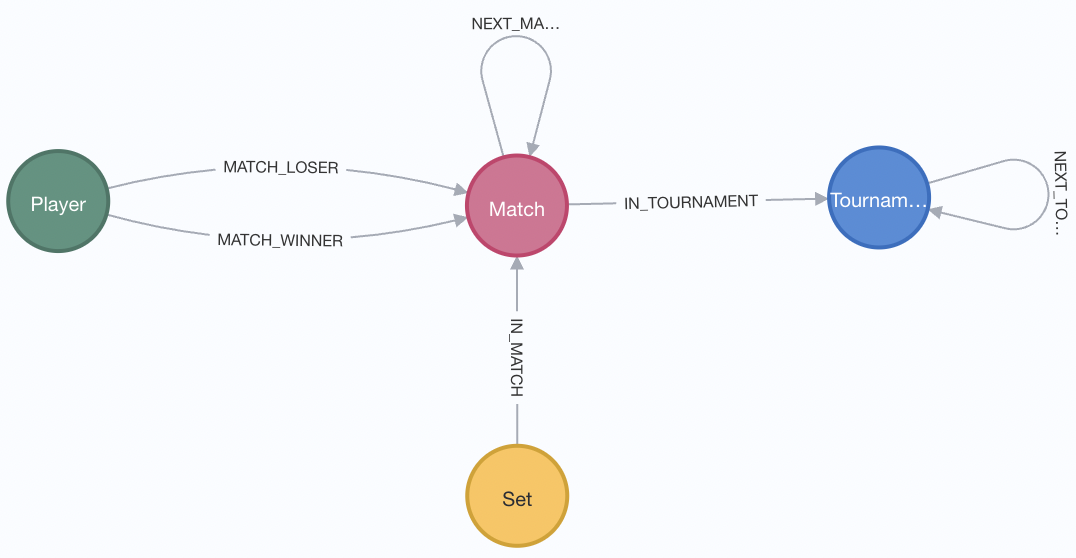

### 🍩 The property types for nodes & relationships in the graph

In [ ]:
query_string = "CALL db.schema.nodeTypeProperties();"
nodeTypes = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
nodeTypes

nodeType       nodeLabels    propertyName propertyTypes  mandatory
0        :`Match`       [Match]      id       [String]      True     
1        :`Match`       [Match]    year         [Long]      True     
2        :`Match`       [Match]   round       [String]      True     
3        :`Match`       [Match]   score       [String]      True     
4          :`Set`         [Set]      id       [String]      True     
5          :`Set`         [Set]   score       [String]      True     
6          :`Set`         [Set]  number         [Long]      True     
7   :`Tournament`  [Tournament]      id       [String]      True     
8   :`Tournament`  [Tournament]    name       [String]      True     
9   :`Tournament`  [Tournament]    year         [Long]      True     
10  :`Tournament`  [Tournament]    type       [String]      True     
11      :`Player`      [Player]      id       [String]      True     
12      :`Player`      [Player]    name       [String]      True     
13      :`Player`      [Player]  gender       [String]      True     
14      :`Player`      [Player]    hand       [String]      True     
15      :`Player`      [Player]     ioc       [String]      True

In [ ]:
query_string = "CALL db.schema.relTypeProperties();"
relTypes = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
relTypes

relType             propertyName propertyTypes  mandatory
0     :`MATCH_WINNER`  None         None          False    
1      :`MATCH_LOSER`  None         None          False    
2    :`IN_TOURNAMENT`  None         None          False    
3         :`IN_MATCH`  None         None          False    
4  :`NEXT_TOURNAMENT`  None         None          False    
5       :`NEXT_MATCH`  None         None          False

## 💥 Graph DB EDA

In [ ]:
query_string = '''
CALL db.labels() YIELD label
CALL apoc.cypher.run('MATCH (:`'+label+'`) RETURN count(*) as count',{}) YIELD value
RETURN label, value.count
'''
edaNodes = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
edaNodes

label        value.count
0      Player   1398      
1       Match  11176      
2         Set  33457      
3  Tournament     88

In [ ]:
query_string = '''
CALL db.relationshipTypes() YIELD relationshipType as type
CALL apoc.cypher.run('MATCH ()-[:`'+type+'`]->() RETURN count(*) as count',{}) YIELD value
RETURN type, value.count
'''
edaRels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
edaRels

type              value.count
0     MATCH_WINNER  11176      
1      MATCH_LOSER  11176      
2    IN_TOURNAMENT  11176      
3         IN_MATCH  33457      
4  NEXT_TOURNAMENT     84      
5       NEXT_MATCH  11088

## 🧗🏽 Distribution of Players

In [ ]:
query_string = """
MATCH (n:Player) 
RETURN n.name as name, n.ioc as country, n.hand as hand, n.gender as gender
"""
players = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
players

name country hand  gender
0       Martina Hingis     SUI    R  Female
1            Julia Abe     GER    R  Female
2         Lisa Raymond     USA    R  Female
3      Tathiana Garbin     ITA    R  Female
4     Denisa Chladkova     CZE    R  Female
...                ...     ...  ...     ...
1393       Max Purcell     AUS    R    Male
1394       Emilio Nava     USA    R    Male
1395       Alex Molcan     SVK    L    Male
1396         Cem Ilkel     TUR    R    Male
1397       Sam Riffice     USA    U    Male

[1398 rows x 4 columns]

In [ ]:
data = players.groupby(['gender', 'hand'])['name'].count().reset_index()
data.rename(columns={'name':'counts'}, inplace=True)

fig = px.bar(data, x="gender", y="counts", color="hand",title="Players by gender and hand", text='counts',
             color_discrete_sequence=[nb_colors[2], nb_colors[5],nb_colors[7]],  #px.colors.qualitative.G10  
             )
fig.show()

In [ ]:
data = players.groupby(['gender', 'country'])['name'].count().reset_index()
data.rename(columns={'name':'counts'}, inplace=True)

countries = players.groupby(['country'])['name'].count().reset_index()
countries = countries.sort_values('name', ascending=False)
top20 = countries.country.unique()[:20]
data = data[data.country.isin(top20)]
data = data.sort_values(by = ['gender', 'counts'], ascending=[False, False])

fig = px.bar(data, x="country", y="counts", color="gender",title="Top 20 countries players distributed by countries and gender", text='counts',
             color_discrete_sequence=px.colors.qualitative.Alphabet ,  #px.colors.qualitative.G10  
             )
fig.show()

## 🥇 Finals of the Tournaments

In [ ]:
query_string = """
MATCH (winner:Player)-[:MATCH_WINNER]->(match:Match {round: "F"})<-[:MATCH_LOSER]-(loser),
      (sets)-[:IN_MATCH]->(match)-[:IN_TOURNAMENT]->(tournament)
RETURN tournament.year AS year, 
       tournament.type AS type,
       tournament.name AS name, 
       winner.gender AS gender,
       winner.hand AS winner_hand,
       winner.ioc AS winner_country,
       winner.name AS winner, 
       loser.name AS loser,
       loser.ioc AS loser_country,
       loser.hand AS loser_hand,
       count(sets) AS number_of_sets,
       match.score AS score
ORDER BY tournament.year
"""
finals = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
finals

year type name           gender  winner_hand winner_country winner                 loser                     loser_country loser_hand  number_of_sets score                     
0   2000  atp  Roland Garros    Male  R           BRA                  Gustavo Kuerten             Magnus Norman  SWE           R          4                      6-2 6-3 2-6 7-6(6)
1   2000  atp        US Open    Male  R           RUS                      Marat Safin              Pete Sampras  USA           R          3                             6-4 6-3 6-3
2   2000  wta  Roland Garros  Female  R           FRA                      Mary Pierce         Conchita Martinez  ESP           R          2                                 6-2 7-5
3   2000  wta        US Open  Female  R           USA                   Venus Williams         Lindsay Davenport  USA           R          2                                 6-4 7-5
4   2001  atp  Roland Garros    Male  R           BRA                  Gustavo Kuerten             Alex Corretja  ESP           R          4                      6-7(3) 7-5 6-2 6-0
5   2001  atp        US Open    Male  R           AUS                   Lleyton Hewitt              Pete Sampras  USA           R          3                          7-6(4) 6-1 6-1
6   2001  wta  Roland Garros  Female  R           USA                Jennifer Capriati             Kim Clijsters  BEL           R          3                           1-6 6-4 12-10
7   2001  wta        US Open  Female  R           USA                   Venus Williams           Serena Williams  USA           R          2                                 6-2 6-4
8   2002  atp  Roland Garros    Male  R           ESP                     Albert Costa       Juan Carlos Ferrero  ESP           R          4                         6-1 6-0 4-6 6-3
9   2002  atp        US Open    Male  R           USA                     Pete Sampras              Andre Agassi  USA           R          4                         6-3 6-4 5-7 6-4
10  2002  wta  Roland Garros  Female  R           USA                  Serena Williams            Venus Williams  USA           R          2                                 7-5 6-3
11  2002  wta        US Open  Female  R           USA                  Serena Williams            Venus Williams  USA           R          2                                 6-4 6-3
12  2003  atp  Roland Garros    Male  R           ESP              Juan Carlos Ferrero            Martin Verkerk  NED           R          3                             6-1 6-3 6-2
13  2003  atp        US Open    Male  R           USA                     Andy Roddick       Juan Carlos Ferrero  ESP           R          3                          6-3 7-6(2) 6-3
14  2003  wta  Roland Garros  Female  R           BEL                    Justine Henin             Kim Clijsters  BEL           R          2                                 6-0 6-4
15  2003  wta        US Open  Female  R           BEL                    Justine Henin             Kim Clijsters  BEL           R          2                                 7-5 6-1
16  2004  atp  Roland Garros    Male  R           ARG                    Gaston Gaudio           Guillermo Coria  ARG           R          5                     0-6 3-6 6-4 6-1 8-6
17  2004  atp        US Open    Male  R           SUI                    Roger Federer            Lleyton Hewitt  AUS           R          3                          6-0 7-6(3) 6-0
18  2004  wta  Roland Garros  Female  R           RUS                Anastasia Myskina          Elena Dementieva  RUS           R          2                                 6-1 6-2
19  2004  wta        US Open  Female  R           RUS              Svetlana Kuznetsova          Elena Dementieva  RUS           R          2                                 6-3 7-5
20  2005  atp  Roland Garros    Male  L           ESP                     Rafael Nadal            Mariano Puerta  ARG           L          4                      6-7(6) 6-3 6-1 7-5
21  2005  atp        U

In [ ]:
query_string = """
MATCH (winner:Player)-[:MATCH_WINNER]->(match:Match {round: "F"})<-[:MATCH_LOSER]-(loser),
      (sets)-[:IN_MATCH]->(match)-[:IN_TOURNAMENT]->(tournament)
RETURN tournament.year AS year, 
       tournament.type AS type,
       tournament.name AS name, 
       winner.gender AS gender,
       winner.hand AS winner_hand,
       winner.ioc AS winner_country,
       winner.name AS winner, 
       loser.name AS loser,
       loser.ioc AS loser_country,
       loser.hand AS loser_hand,
       apoc.coll.sortMaps(COLLECT({num:sets.number,set:sets.score}),'^num') AS scores,
       count(sets) AS number_of_sets,
       match.score AS score
ORDER BY tournament.year
"""
finals = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
finals

year type name           gender  winner_hand winner_country winner                 loser                     loser_country loser_hand scores                                                                                                                                     number_of_sets score                     
0   2000  atp  Roland Garros    Male  R           BRA                  Gustavo Kuerten             Magnus Norman  SWE           R                                       [{'set': '6-2', 'num': 1}, {'set': '6-3', 'num': 2}, {'set': '2-6', 'num': 3}, {'set': '7-6(6)', 'num': 4}]  4                      6-2 6-3 2-6 7-6(6)
1   2000  atp        US Open    Male  R           RUS                      Marat Safin              Pete Sampras  USA           R                                                                    [{'set': '6-4', 'num': 1}, {'set': '6-3', 'num': 2}, {'set': '6-3', 'num': 3}]  3                             6-4 6-3 6-3
2   2000  wta  Roland Garros  Female  R           FRA                      Mary Pierce         Conchita Martinez  ESP           R                                                                                              [{'set': '6-2', 'num': 1}, {'set': '7-5', 'num': 2}]  2                                 6-2 7-5
3   2000  wta        US Open  Female  R           USA                   Venus Williams         Lindsay Davenport  USA           R                                                                                              [{'set': '6-4', 'num': 1}, {'set': '7-5', 'num': 2}]  2                                 6-4 7-5
4   2001  atp  Roland Garros    Male  R           BRA                  Gustavo Kuerten             Alex Corretja  ESP           R                                       [{'set': '6-7(3)', 'num': 1}, {'set': '7-5', 'num': 2}, {'set': '6-2', 'num': 3}, {'set': '6-0', 'num': 4}]  4                      6-7(3) 7-5 6-2 6-0
5   2001  atp        US Open    Male  R           AUS                   Lleyton Hewitt              Pete Sampras  USA           R                                                                 [{'set': '7-6(4)', 'num': 1}, {'set': '6-1', 'num': 2}, {'set': '6-1', 'num': 3}]  3                          7-6(4) 6-1 6-1
6   2001  wta  Roland Garros  Female  R           USA                Jennifer Capriati             Kim Clijsters  BEL           R                                                                  [{'set': '1-6', 'num': 1}, {'set': '6-4', 'num': 2}, {'set': '12-10', 'num': 3}]  3                           1-6 6-4 12-10
7   2001  wta        US Open  Female  R           USA                   Venus Williams           Serena Williams  USA           R                                                                                              [{'set': '6-2', 'num': 1}, {'set': '6-4', 'num': 2}]  2                                 6-2 6-4
8   2002  atp  Roland Garros    Male  R           ESP                     Albert Costa       Juan Carlos Ferrero  ESP           R                                          [{'set': '6-1', 'num': 1}, {'set': '6-0', 'num': 2}, {'set': '4-6', 'num': 3}, {'set': '6-3', 'num': 4}]  4                         6-1 6-0 4-6 6-3
9   2002  atp        US Open    Male  R           USA                     Pete Sampras              Andre Agassi  USA           R                                          [{'set': '6-3', 'num': 1}, {'set': '6-4', 'num': 2}, {'set': '5-7', 'num': 3}, {'set': '6-4', 'num': 4}]  4                         6-3 6-4 5-7 6-4
10  2002  wta  Roland Garros  Female  R           USA                  Serena Williams            Venus Williams  USA           R                                                                                              [{'set': '7-5', 'num': 1}, {'set': '6-3', 'num': 2}]  2                                 7-5 6-3
11  2002  wta        US Open  Female  R           USA                  Serena Williams            Venus Williams  USA           R                                               

In [ ]:
query_string = """
MATCH (winner:Player)-[:MATCH_WINNER]->(match:Match {round: "F"})<-[:MATCH_LOSER]-(loser),
      (sets)-[:IN_MATCH]->(match)-[:IN_TOURNAMENT]->(tournament)
RETURN DISTINCT tournament.year AS year, 
       tournament.type AS type,
       tournament.name AS name, 
       winner.name + "-" +  winner.hand + "-" + winner.ioc AS winner_hand_country
ORDER BY tournament.year
"""
finals = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
finals

year type name           winner_hand_country         
0   2000  atp  Roland Garros        Gustavo Kuerten-R-BRA
1   2000  atp        US Open            Marat Safin-R-RUS
2   2000  wta  Roland Garros            Mary Pierce-R-FRA
3   2000  wta        US Open         Venus Williams-R-USA
4   2001  atp  Roland Garros        Gustavo Kuerten-R-BRA
5   2001  atp        US Open         Lleyton Hewitt-R-AUS
6   2001  wta  Roland Garros      Jennifer Capriati-R-USA
7   2001  wta        US Open         Venus Williams-R-USA
8   2002  atp  Roland Garros           Albert Costa-R-ESP
9   2002  atp        US Open           Pete Sampras-R-USA
10  2002  wta  Roland Garros        Serena Williams-R-USA
11  2002  wta        US Open        Serena Williams-R-USA
12  2003  atp  Roland Garros    Juan Carlos Ferrero-R-ESP
13  2003  atp        US Open           Andy Roddick-R-USA
14  2003  wta  Roland Garros          Justine Henin-R-BEL
15  2003  wta        US Open          Justine Henin-R-BEL
16  2004  atp  Roland Garros          Gaston Gaudio-R-ARG
17  2004  atp        US Open          Roger Federer-R-SUI
18  2004  wta  Roland Garros      Anastasia Myskina-R-RUS
19  2004  wta        US Open    Svetlana Kuznetsova-R-RUS
20  2005  atp  Roland Garros           Rafael Nadal-L-ESP
21  2005  atp        US Open          Roger Federer-R-SUI
22  2005  wta  Roland Garros          Justine Henin-R-BEL
23  2005  wta        US Open          Kim Clijsters-R-BEL
24  2006  atp  Roland Garros           Rafael Nadal-L-ESP
25  2006  atp        US Open          Roger Federer-R-SUI
26  2006  wta  Roland Garros          Justine Henin-R-BEL
27  2006  wta        US Open        Maria Sharapova-R-RUS
28  2007  atp  Roland Garros           Rafael Nadal-L-ESP
29  2007  atp        US Open          Roger Federer-R-SUI
30  2007  wta  Roland Garros          Justine Henin-R-BEL
31  2007  wta        US Open          Justine Henin-R-BEL
32  2008  atp  Roland Garros           Rafael Nadal-L-ESP
33  2008  atp        US Open          Roger Federer-R-SUI
34  2008  wta  Roland Garros           Ana Ivanovic-R-SRB
35  2008  wta        US Open        Serena Williams-R-USA
36  2009  atp  Roland Garros          Roger Federer-R-SUI
37  2009  atp        US Open  Juan Martin del Potro-R-ARG
38  2009  wta  Roland Garros    Svetlana Kuznetsova-R-RUS
39  2009  wta        US Open          Kim Clijsters-R-BEL
40  2010  atp  Roland Garros           Rafael Nadal-L-ESP
41  2010  atp        US Open           Rafael Nadal-L-ESP
42  2010  wta  Roland Garros    Francesca Schiavone-R-ITA
43  2010  wta        US Open          Kim Clijsters-R-BEL
44  2011  atp  Roland Garros           Rafael Nadal-L-ESP
45  2011  atp        US Open         Novak Djokovic-R-SRB
46  2011  wta  Roland Garros                  Na Li-R-CHN
47  2011  wta        US Open        Samantha Stosur-R-AUS
48  2012  atp  Roland Garros           Rafael Nadal-L-ESP
49  2012  atp        US Open            Andy Murray-R-GBR
50  2012  wta  Roland Garros        Maria Sharapova-R-RUS
51  2012  wta        US Open        Serena Williams-R-USA
52  2013  atp  Roland Garros           Rafael Nadal-L-ESP
53  2013  atp        US Open           Rafael Nadal-L-ESP
54  2013  wta  Roland Garros        Serena Williams-R-USA
55  2013  wta        US Open        Serena Williams-R-USA
56  2014  atp  Roland Garros           Rafael Nadal-L-ESP
57  2014  atp        US Open            Marin Cilic-R-CRO
58  2014  wta  Roland Garros        Maria Sharapova-R-RUS
59  2014  wta        US Open        Serena Williams-R-USA
60  2015  atp  Roland Garros          Stan Wawrinka-R-SUI
61  2015  atp        US Open         Novak Djokovic-R-SRB
62  2015  wta  Roland Garros        Serena Williams-R-USA
63  2015  wta        US Open        Flavia Pennetta-R-ITA
64  2016  atp  Roland Garros         Novak Djokovic-R-SRB
65  2016  atp        US Open          Stan Wawrinka-R-SUI
66  2016  wta  Roland Garros       Garbine Muguruza-R-ESP
67  2016  wta        US Open       Angelique Kerber-L-GER
68

In [ ]:
final_df = pd.pivot(finals, index='year', columns=['name', 'type'], values='winner_hand_country')
final_df.columns = [f'{col[0]}-{col[1]}' for col in final_df.columns]
final_df

Roland Garros-atp          US Open-atp                  Roland Garros-wta          US Open-wta               
year                                                                                                              
2000      Gustavo Kuerten-R-BRA            Marat Safin-R-RUS          Mary Pierce-R-FRA       Venus Williams-R-USA
2001      Gustavo Kuerten-R-BRA         Lleyton Hewitt-R-AUS    Jennifer Capriati-R-USA       Venus Williams-R-USA
2002         Albert Costa-R-ESP           Pete Sampras-R-USA      Serena Williams-R-USA      Serena Williams-R-USA
2003  Juan Carlos Ferrero-R-ESP           Andy Roddick-R-USA        Justine Henin-R-BEL        Justine Henin-R-BEL
2004        Gaston Gaudio-R-ARG          Roger Federer-R-SUI    Anastasia Myskina-R-RUS  Svetlana Kuznetsova-R-RUS
2005         Rafael Nadal-L-ESP          Roger Federer-R-SUI        Justine Henin-R-BEL        Kim Clijsters-R-BEL
2006         Rafael Nadal-L-ESP          Roger Federer-R-SUI        Justine Henin-R-BEL      Maria Sharapova-R-RUS
2007         Rafael Nadal-L-ESP          Roger Federer-R-SUI        Justine Henin-R-BEL        Justine Henin-R-BEL
2008         Rafael Nadal-L-ESP          Roger Federer-R-SUI         Ana Ivanovic-R-SRB      Serena Williams-R-USA
2009        Roger Federer-R-SUI  Juan Martin del Potro-R-ARG  Svetlana Kuznetsova-R-RUS        Kim Clijsters-R-BEL
2010         Rafael Nadal-L-ESP           Rafael Nadal-L-ESP  Francesca Schiavone-R-ITA        Kim Clijsters-R-BEL
2011         Rafael Nadal-L-ESP         Novak Djokovic-R-SRB                Na Li-R-CHN      Samantha Stosur-R-AUS
2012         Rafael Nadal-L-ESP            Andy Murray-R-GBR      Maria Sharapova-R-RUS      Serena Williams-R-USA
2013         Rafael Nadal-L-ESP           Rafael Nadal-L-ESP      Serena Williams-R-USA      Serena Williams-R-USA
2014         Rafael Nadal-L-ESP            Marin Cilic-R-CRO      Maria Sharapova-R-RUS      Serena Williams-R-USA
2015        Stan Wawrinka-R-SUI         Novak Djokovic-R-SRB      Serena Williams-R-USA      Flavia Pennetta-R-ITA
2016       Novak Djokovic-R-SRB          Stan Wawrinka-R-SUI     Garbine Muguruza-R-ESP     Angelique Kerber-L-GER
2017         Rafael Nadal-L-ESP           Rafael Nadal-L-ESP     Jelena Ostapenko-R-LAT      Sloane Stephens-R-USA
2018         Rafael Nadal-L-ESP         Novak Djokovic-R-SRB         Simona Halep-R-ROU          Naomi Osaka-R-JPN
2019         Rafael Nadal-L-ESP           Rafael Nadal-L-ESP       Ashleigh Barty-R-AUS     Bianca Andreescu-R-CAN
2020         Rafael Nadal-L-ESP          Dominic Thiem-R-AUT          Iga Swiatek-R-POL          Naomi Osaka-R-JPN
2021       Novak Djokovic-R-SRB        Daniil Medvedev-R-RUS   Barbora Krejcikova-R-CZE        Emma Raducanu-R-GBR

In [ ]:
fig = go.Figure()

colors = px.colors.qualitative.G10

top_labels = final_df.columns
x_data = np.ones(final_df.shape, dtype=int)
winners = final_df.to_numpy()
y_data = final_df.index

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=2)
            )
        ))

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=10, r=10, t=100, b=90),
    showlegend=False,
)

annotations = []

for yd, xd, winner in zip(y_data, x_data, winners):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first percentage of each bar (x_axis)
    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(winner[0]),
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the rest of percentages for each bar (x_axis)
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(winner[i]),
                                    font=dict(family='Arial', size=14,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations, 
    autosize=False,
    width=1000,
    height=800,)

fig.show()

In [ ]:
final_df = pd.pivot(finals, index='year', columns=['name', 'type'], values='winner')
final_df.columns = [f'{col[0]}-{col[1]}' for col in final_df.columns]
final_df

Roland Garros-atp    US Open-atp            Roland Garros-wta    US Open-wta         
year                                                                                      
2000      Gustavo Kuerten            Marat Safin          Mary Pierce       Venus Williams
2001      Gustavo Kuerten         Lleyton Hewitt    Jennifer Capriati       Venus Williams
2002         Albert Costa           Pete Sampras      Serena Williams      Serena Williams
2003  Juan Carlos Ferrero           Andy Roddick        Justine Henin        Justine Henin
2004        Gaston Gaudio          Roger Federer    Anastasia Myskina  Svetlana Kuznetsova
2005         Rafael Nadal          Roger Federer        Justine Henin        Kim Clijsters
2006         Rafael Nadal          Roger Federer        Justine Henin      Maria Sharapova
2007         Rafael Nadal          Roger Federer        Justine Henin        Justine Henin
2008         Rafael Nadal          Roger Federer         Ana Ivanovic      Serena Williams
2009        Roger Federer  Juan Martin del Potro  Svetlana Kuznetsova        Kim Clijsters
2010         Rafael Nadal           Rafael Nadal  Francesca Schiavone        Kim Clijsters
2011         Rafael Nadal         Novak Djokovic                Na Li      Samantha Stosur
2012         Rafael Nadal            Andy Murray      Maria Sharapova      Serena Williams
2013         Rafael Nadal           Rafael Nadal      Serena Williams      Serena Williams
2014         Rafael Nadal            Marin Cilic      Maria Sharapova      Serena Williams
2015        Stan Wawrinka         Novak Djokovic      Serena Williams      Flavia Pennetta
2016       Novak Djokovic          Stan Wawrinka     Garbine Muguruza     Angelique Kerber
2017         Rafael Nadal           Rafael Nadal     Jelena Ostapenko      Sloane Stephens
2018         Rafael Nadal         Novak Djokovic         Simona Halep          Naomi Osaka
2019         Rafael Nadal           Rafael Nadal       Ashleigh Barty     Bianca Andreescu
2020         Rafael Nadal          Dominic Thiem          Iga Swiatek          Naomi Osaka
2021       Novak Djokovic        Daniil Medvedev   Barbora Krejcikova        Emma Raducanu

In [ ]:
fig = go.Figure()

# colors = [nb_colors[-1], nb_colors[2],nb_colors[0],nb_colors[1]]
# colors = [px.colors.qualitative.Alphabet[1], px.colors.qualitative.Alphabet[13],]
colors = px.colors.qualitative.G10

top_labels = final_df.columns
x_data = np.ones(final_df.shape, dtype=int)
winners = final_df.to_numpy()
y_data = final_df.index

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=2)
            )
        ))

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=10, r=10, t=10, b=90),
    showlegend=False,
)

annotations = []

for yd, xd, winner in zip(y_data, x_data, winners):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first percentage of each bar (x_axis)
    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(winner[0]),
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the rest of percentages for each bar (x_axis)
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(winner[i]),
                                    font=dict(family='Arial', size=14,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations, 
    autosize=False,
    width=1000,
    height=800,)

fig.show()

In [ ]:
runnerups_df = pd.pivot(finals, index='year', columns=['name', 'type'], values='loser')
runnerups_df.columns = [f'{col[0]}-{col[1]}' for col in runnerups_df.columns]
runnerups_df

Roland Garros-atp    US Open-atp            Roland Garros-wta         US Open-wta         
year                                                                                           
2000        Magnus Norman           Pete Sampras         Conchita Martinez    Lindsay Davenport
2001        Alex Corretja           Pete Sampras             Kim Clijsters      Serena Williams
2002  Juan Carlos Ferrero           Andre Agassi            Venus Williams       Venus Williams
2003       Martin Verkerk    Juan Carlos Ferrero             Kim Clijsters        Kim Clijsters
2004      Guillermo Coria         Lleyton Hewitt          Elena Dementieva     Elena Dementieva
2005       Mariano Puerta           Andre Agassi               Mary Pierce          Mary Pierce
2006        Roger Federer           Andy Roddick       Svetlana Kuznetsova        Justine Henin
2007        Roger Federer         Novak Djokovic              Ana Ivanovic  Svetlana Kuznetsova
2008        Roger Federer            Andy Murray             Dinara Safina      Jelena Jankovic
2009      Robin Soderling          Roger Federer             Dinara Safina   Caroline Wozniacki
2010      Robin Soderling         Novak Djokovic           Samantha Stosur       Vera Zvonareva
2011        Roger Federer           Rafael Nadal       Francesca Schiavone      Serena Williams
2012       Novak Djokovic         Novak Djokovic               Sara Errani    Victoria Azarenka
2013         David Ferrer         Novak Djokovic           Maria Sharapova    Victoria Azarenka
2014       Novak Djokovic          Kei Nishikori              Simona Halep   Caroline Wozniacki
2015       Novak Djokovic          Roger Federer            Lucie Safarova        Roberta Vinci
2016          Andy Murray         Novak Djokovic           Serena Williams    Karolina Pliskova
2017        Stan Wawrinka         Kevin Anderson              Simona Halep         Madison Keys
2018        Dominic Thiem  Juan Martin del Potro           Sloane Stephens      Serena Williams
2019        Dominic Thiem        Daniil Medvedev       Marketa Vondrousova      Serena Williams
2020       Novak Djokovic       Alexander Zverev               Sofia Kenin    Victoria Azarenka
2021   Stefanos Tsitsipas         Novak Djokovic  Anastasia Pavlyuchenkova     Leylah Fernandez

In [ ]:
fig = go.Figure()

colors = [nb_colors[-1], nb_colors[2],nb_colors[0],nb_colors[1]]
colors = px.colors.qualitative.Bold[1:5]

top_labels = runnerups_df.columns
x_data = np.ones(runnerups_df.shape, dtype=int)
winners = runnerups_df.to_numpy()
y_data = runnerups_df.index

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=2)
            )
        ))

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=10, r=10, t=150, b=90),
    showlegend=False,
)

annotations = []

for yd, xd, winner in zip(y_data, x_data, winners):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first percentage of each bar (x_axis)
    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(winner[0]),
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the rest of percentages for each bar (x_axis)
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(winner[i]),
                                    font=dict(family='Arial', size=14,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations, 
    autosize=False,
    width=1000,
    height=800,)

fig.show()

In [ ]:
winners_grp = finals.groupby(['gender','winner'])['name'].count().reset_index()
winners_grp.rename(columns={'name':'counts'}, inplace=True)
winners_grp = winners_grp.sort_values('counts', ascending=False)
data = winners_grp[winners_grp.counts>1]
data
fig = px.bar(data, orientation='h', y="winner", x="counts", color="gender", title="Top Winners", text='counts',
             color_discrete_sequence=px.colors.qualitative.Dark24 ,  #px.colors.qualitative.G10  
             )

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
),
uniformtext_minsize=14, uniformtext_mode='hide')

fig.show()

In [ ]:
losers_grp = finals.groupby(['gender','loser'])['name'].count().reset_index()
losers_grp.rename(columns={'name':'counts'}, inplace=True)
losers_grp = losers_grp.sort_values('counts', ascending=False)
data = losers_grp[losers_grp.counts>1]
data
fig = px.bar(data, orientation='h', y="loser", x="counts", color="gender", title="Top Runners-up", text='counts',
             color_discrete_sequence=px.colors.qualitative.Dark24 ,  #px.colors.qualitative.G10  
             )

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
),
uniformtext_minsize=14, uniformtext_mode='hide')

fig.show()

## 🏆 Novak Djokovic's route at the Roland Garros-2021 as a champion

In [ ]:
query_string = """
MATCH path = (p:Player)-[:MATCH_WINNER]->(final:Match {round: "F"})<-[:NEXT_MATCH*]-(m)<-[:MATCH_WINNER]-(p)
WHERE not((m)<-[:NEXT_MATCH]-()) AND (final)-[:IN_TOURNAMENT]-(:Tournament{name:'Roland Garros', type:'atp', year:2021})
RETURN path,
       [node in nodes(path) WHERE node:Match | [p = (p1)-[:MATCH_WINNER]->(node)<-[:MATCH_LOSER]-(p2) | p]];
"""
Djokovic_route_2021 = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

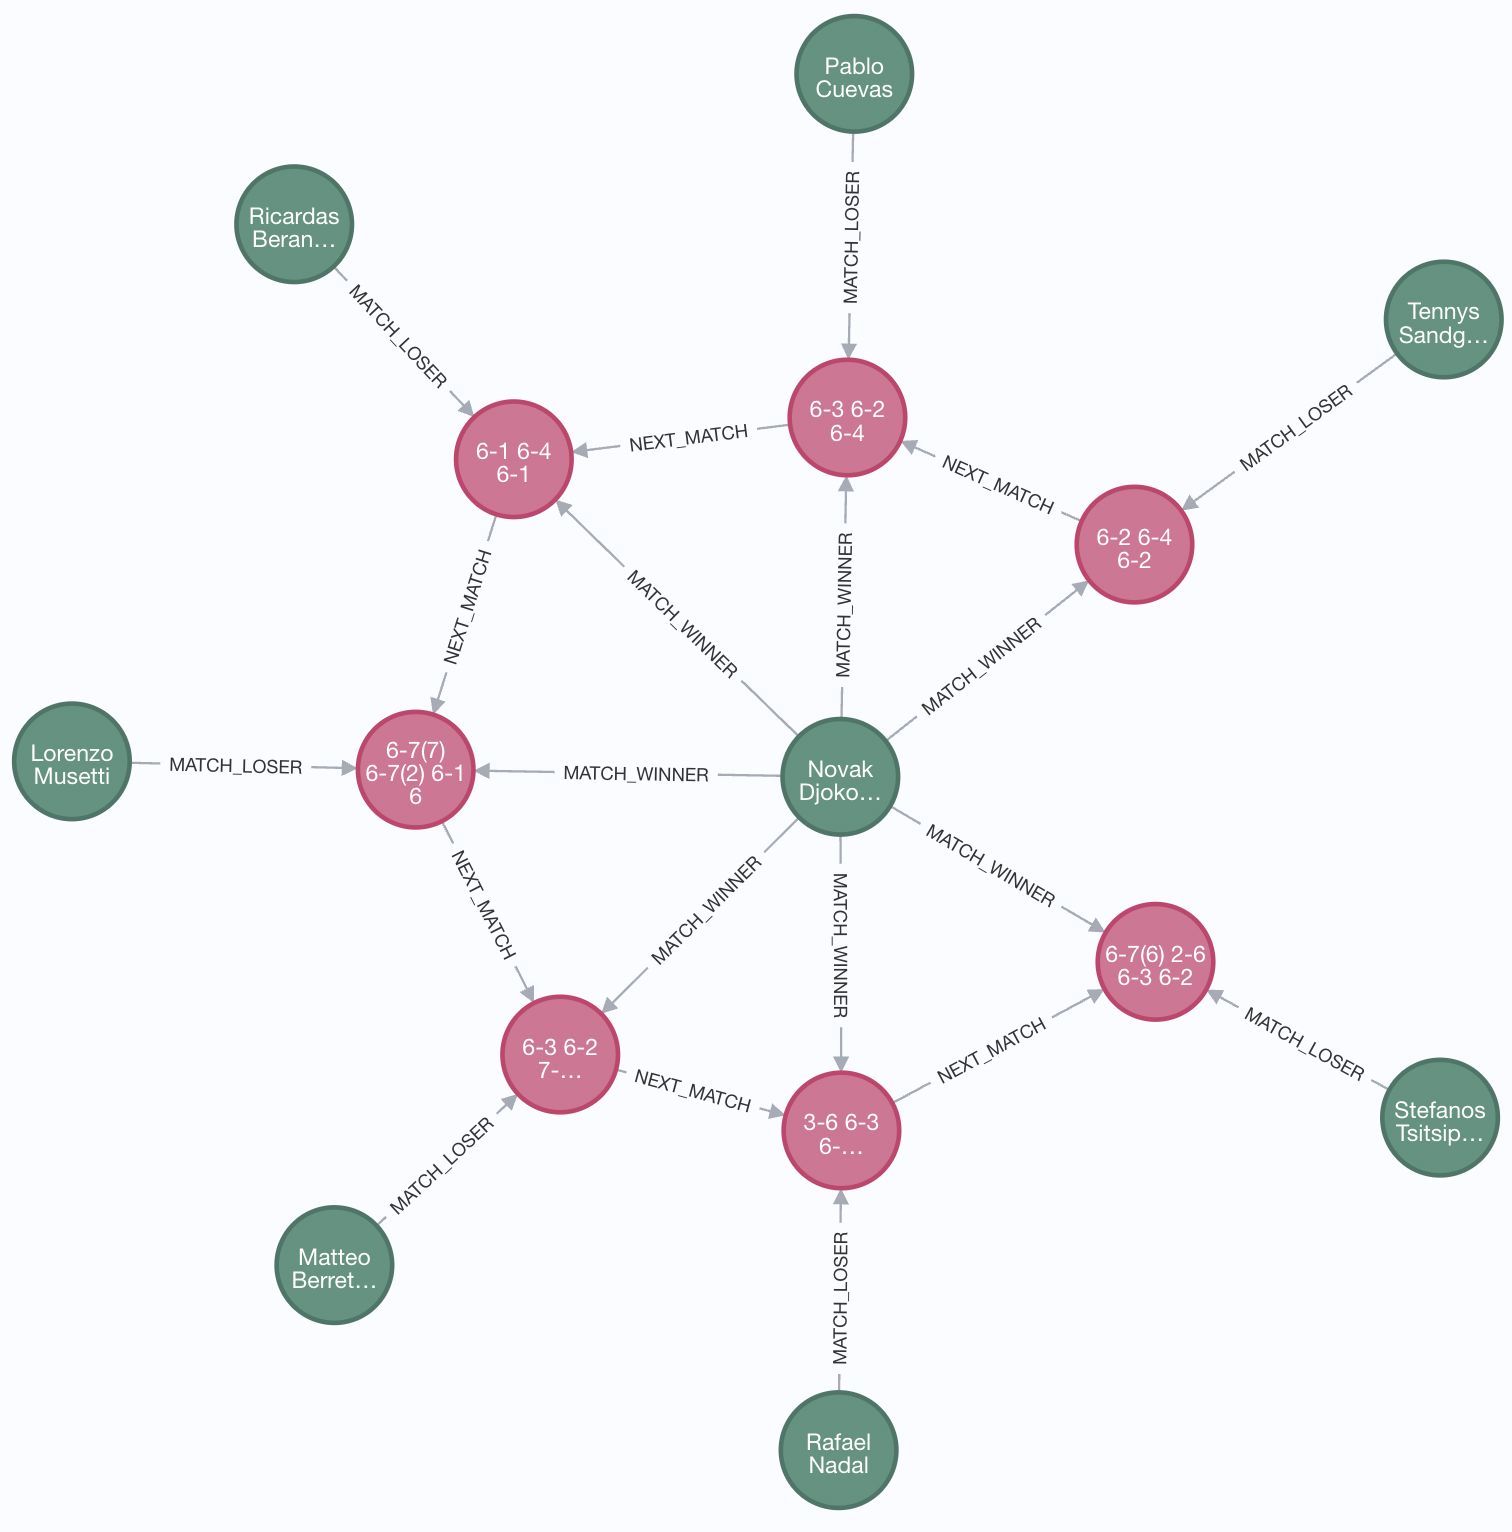

In [ ]:
query_string = """
MATCH (winner:Player{name:'Novak Djokovic'})-[:MATCH_WINNER]->(match:Match)<-[:MATCH_LOSER]-(loser),
      (sets)-[:IN_MATCH]->(match)-[:IN_TOURNAMENT]->(tournament:Tournament{name:'Roland Garros', type:'atp', year:2021})
RETURN winner.ioc AS winner_country,
       winner.name AS winner, 
       loser.name AS loser,
       loser.ioc AS loser_country,
       match.round AS rounds,
       match.score AS sets,
       count(sets) AS number_of_sets;
"""
Djokovic_route_2021 = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
Djokovic_route_2021

winner_country          winner               loser loser_country rounds                           sets  number_of_sets
0            SRB  Novak Djokovic  Stefanos Tsitsipas           GRE      F         6-7(6) 2-6 6-3 6-2 6-4               5
1            SRB  Novak Djokovic   Matteo Berrettini           ITA     QF             6-3 6-2 6-7(5) 7-5               4
2            SRB  Novak Djokovic        Rafael Nadal           ESP     SF             3-6 6-3 7-6(4) 6-2               4
3            SRB  Novak Djokovic   Ricardas Berankis           LTU    R32                    6-1 6-4 6-1               3
4            SRB  Novak Djokovic     Lorenzo Musetti           ITA    R16  6-7(7) 6-7(2) 6-1 6-0 4-0 RET               6
5            SRB  Novak Djokovic        Pablo Cuevas           URU    R64                    6-3 6-2 6-4               3
6            SRB  Novak Djokovic     Tennys Sandgren           USA   R128                    6-2 6-4 6-2               3

## 🧗 Players who were the runners-up in the previous year and the winners the following year

In [ ]:
query_string = """
MATCH (player)-[:MATCH_LOSER]->(:Match {round: "F"})-[:IN_TOURNAMENT]->(t_prev)-[:NEXT_TOURNAMENT]->(t_next),
      (player)-[:MATCH_WINNER]->(:Match {round: "F"})-[:IN_TOURNAMENT]->(t_next)
RETURN player.name AS player, t_prev.year AS prev_year, t_next.year AS next_year, t_next.name AS tournament_name, player.gender AS gender
ORDER BY prev_year DESC;
"""
loser_winner = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
loser_winner

player                prev_year  next_year tournament_name gender 
0        Novak Djokovic  2020       2021       Roland Garros     Male
1          Simona Halep  2017       2018       Roland Garros   Female
2        Novak Djokovic  2015       2016       Roland Garros     Male
3       Maria Sharapova  2013       2014       Roland Garros   Female
4       Serena Williams  2011       2012             US Open   Female
5        Novak Djokovic  2010       2011             US Open     Male
6         Roger Federer  2008       2009       Roland Garros     Male
7          Ana Ivanovic  2007       2008       Roland Garros   Female
8         Justine Henin  2006       2007             US Open   Female
9   Juan Carlos Ferrero  2002       2003       Roland Garros     Male
10         Pete Sampras  2001       2002             US Open     Male
11      Serena Williams  2001       2002             US Open   Female

## 🎖️ Players who lost before QF in the previous year but won the tournament the following year

In [ ]:
query_string = """
MATCH (player)-[:MATCH_LOSER]->(m:Match)-[:IN_TOURNAMENT]->(prev_t)-[:NEXT_TOURNAMENT]->(next_t),
      (player)-[:MATCH_WINNER]->(:Match {round: "F"})-[:IN_TOURNAMENT]->(next_t)
WHERE m.round in ['R128', 'R64', 'R32', 'R16']
RETURN player.name AS player, m.round AS lost_round, prev_t.year AS lost_year, next_t.year AS won_year, next_t.name AS tournament_name, player.gender AS gender
ORDER BY lost_year DESC;
"""
loser_winner = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
loser_winner

player               lost_round  lost_year  won_year tournament_name gender 
0    Barbora Krejcikova   R16       2020       2021      Roland Garros   Female
1         Dominic Thiem  R128       2019       2020            US Open     Male
2           Iga Swiatek   R16       2019       2020      Roland Garros   Female
3           Naomi Osaka   R16       2019       2020            US Open   Female
4        Ashleigh Barty   R64       2018       2019      Roland Garros   Female
5           Naomi Osaka   R32       2017       2018            US Open   Female
6          Rafael Nadal   R32       2016       2017      Roland Garros     Male
7          Rafael Nadal   R16       2016       2017            US Open     Male
8      Jelena Ostapenko  R128       2016       2017      Roland Garros   Female
9      Angelique Kerber   R32       2015       2016            US Open   Female
10        Stan Wawrinka  R128       2014       2015      Roland Garros     Male
11      Serena Williams   R64       2014       2015      Roland Garros   Female
12      Serena Williams  R128       2012       2013      Roland Garros   Female
13                Na Li   R32       2010       2011      Roland Garros   Female
14         Rafael Nadal   R16       2009       2010      Roland Garros     Male
15  Francesca Schiavone  R128       2009       2010      Roland Garros   Female
16        Justine Henin   R64       2004       2005      Roland Garros   Female
17        Gaston Gaudio   R32       2003       2004      Roland Garros     Male
18        Roger Federer   R16       2003       2004            US Open     Male
19    Anastasia Myskina   R64       2003       2004      Roland Garros   Female
20  Svetlana Kuznetsova   R32       2003       2004            US Open   Female
21        Justine Henin  R128       2002       2003      Roland Garros   Female
22        Justine Henin   R16       2002       2003            US Open   Female
23         Albert Costa  R128       2001       2002      Roland Garros     Male
24    Jennifer Capriati  R128       2000       2001      Roland Garros   Female

## 🍭 Players who have been champions at least twice

In [ ]:
query_string = """
MATCH(winner:Player)-[r1:MATCH_WINNER]->(final:Match{round:'F'})-[:IN_TOURNAMENT]->(t:Tournament)
WITH winner.name as winner,  type(r1) as won, final.year as year, t.name as tournament_name, t.type as type
WITH winner, tournament_name, type, count(year) as times, collect(year) as years
WHERE times>1
RETURN *
ORDER BY times DESC;
"""
winners_journey = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
winners_journey

times tournament_name type winner           years                                                                          
0   13     Roland Garros   atp     Rafael Nadal  [2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2014, 2017, 2018, 2019, 2020]
1    5           US Open   atp    Roger Federer                                                  [2004, 2005, 2006, 2007, 2008]
2    5           US Open   wta  Serena Williams                                                  [2002, 2008, 2012, 2013, 2014]
3    4           US Open   atp     Rafael Nadal                                                        [2010, 2013, 2017, 2019]
4    4     Roland Garros   wta    Justine Henin                                                        [2003, 2005, 2006, 2007]
5    3           US Open   atp   Novak Djokovic                                                              [2011, 2015, 2018]
6    3     Roland Garros   wta  Serena Williams                                                              [2002, 2013, 2015]
7    3           US Open   wta    Kim Clijsters                                                              [2005, 2009, 2010]
8    2     Roland Garros   atp  Gustavo Kuerten                                                                    [2000, 2001]
9    2     Roland Garros   atp   Novak Djokovic                                                                    [2016, 2021]
10   2           US Open   wta   Venus Williams                                                                    [2000, 2001]
11   2           US Open   wta    Justine Henin                                                                    [2003, 2007]
12   2     Roland Garros   wta  Maria Sharapova                                                                    [2012, 2014]
13   2           US Open   wta      Naomi Osaka                                                                    [2018, 2020]

## 🏆🏆🏆 Tournament winning streaks 🏆🏆🏆

In [ ]:
def get_streaks(l:list):
    res = [[]]
    for item1, item2 in zip(l, l[1:]):  # pairwise iteration
        if item2 - item1 == 1:
            # The difference is 1, if we're at the beginning of a sequence add both
            # to the result, otherwise just the second one (the first one is already
            # included because of the previous iteration).
            if not res[-1]: 
                res[-1].extend((item1, item2))
            else:
                res[-1].append(item2)
        elif res[-1]: 
            # The difference isn't 1 so add a new empty list in case it just ended a sequence.
            res.append([])

    # In case "l" doesn't end with a "sequence" one needs to remove the trailing empty list.
    if not res[-1]:
        del res[-1]

    res = sorted(res, key=len)
    elem = []
    if len(res)>0:
        elem = res[-1]
    return len(elem), elem

In [ ]:
winners_journey[['streaks', 'streak_years']] = winners_journey.apply(lambda row: pd.Series(get_streaks(row['years'])), axis=1)
winners_journey

times tournament_name type winner           years                                                                            streaks streak_years                   
0   13     Roland Garros   atp     Rafael Nadal  [2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2014, 2017, 2018, 2019, 2020]  5        [2010, 2011, 2012, 2013, 2014]
1    5           US Open   atp    Roger Federer                                                  [2004, 2005, 2006, 2007, 2008]  5        [2004, 2005, 2006, 2007, 2008]
2    5           US Open   wta  Serena Williams                                                  [2002, 2008, 2012, 2013, 2014]  3                    [2012, 2013, 2014]
3    4           US Open   atp     Rafael Nadal                                                        [2010, 2013, 2017, 2019]  0                                    []
4    4     Roland Garros   wta    Justine Henin                                                        [2003, 2005, 2006, 2007]  3                    [2005, 2006, 2007]
5    3           US Open   atp   Novak Djokovic                                                              [2011, 2015, 2018]  0                                    []
6    3     Roland Garros   wta  Serena Williams                                                              [2002, 2013, 2015]  0                                    []
7    3           US Open   wta    Kim Clijsters                                                              [2005, 2009, 2010]  2                          [2009, 2010]
8    2     Roland Garros   atp  Gustavo Kuerten                                                                    [2000, 2001]  2                          [2000, 2001]
9    2     Roland Garros   atp   Novak Djokovic                                                                    [2016, 2021]  0                                    []
10   2           US Open   wta   Venus Williams                                                                    [2000, 2001]  2                          [2000, 2001]
11   2           US Open   wta    Justine Henin                                                                    [2003, 2007]  0                                    []
12   2     Roland Garros   wta  Maria Sharapova                                                                    [2012, 2014]  0                                    []
13   2           US Open   wta      Naomi Osaka                                                                    [2018, 2020]  0                                    []

In [ ]:
winners_journey.sort_values(by=['streaks', 'times'], ascending=False).query('streaks > 0')

times tournament_name type winner           years                                                                            streaks streak_years                   
0   13     Roland Garros   atp     Rafael Nadal  [2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2014, 2017, 2018, 2019, 2020]  5        [2010, 2011, 2012, 2013, 2014]
1    5           US Open   atp    Roger Federer                                                  [2004, 2005, 2006, 2007, 2008]  5        [2004, 2005, 2006, 2007, 2008]
2    5           US Open   wta  Serena Williams                                                  [2002, 2008, 2012, 2013, 2014]  3                    [2012, 2013, 2014]
4    4     Roland Garros   wta    Justine Henin                                                        [2003, 2005, 2006, 2007]  3                    [2005, 2006, 2007]
7    3           US Open   wta    Kim Clijsters                                                              [2005, 2009, 2010]  2                          [2009, 2010]
8    2     Roland Garros   atp  Gustavo Kuerten                                                                    [2000, 2001]  2                          [2000, 2001]
10   2           US Open   wta   Venus Williams                                                                    [2000, 2001]  2                          [2000, 2001]

## 😥 Players who have been runners-up at least twice

In [ ]:
query_string = """
MATCH(loser:Player)-[r1:MATCH_LOSER]->(final:Match{round:'F'})-[:IN_TOURNAMENT]->(t:Tournament)
WITH loser.name as loser,  final.year as year, t.name as tournament_name, t.type as type 
WITH loser, tournament_name, type, count(year) as times, collect(year) as years
WHERE times>1
RETURN *
ORDER BY times DESC;
"""
runner_ups = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
runner_ups

loser                times tournament_name type years                                
0       Novak Djokovic  6            US Open   atp  [2007, 2010, 2012, 2013, 2016, 2021]
1        Roger Federer  4      Roland Garros   atp              [2006, 2007, 2008, 2011]
2       Novak Djokovic  4      Roland Garros   atp              [2012, 2014, 2015, 2020]
3      Serena Williams  4            US Open   wta              [2001, 2011, 2018, 2019]
4    Victoria Azarenka  3            US Open   wta                    [2012, 2013, 2020]
5         Pete Sampras  2            US Open   atp                          [2000, 2001]
6         Andre Agassi  2            US Open   atp                          [2002, 2005]
7      Robin Soderling  2      Roland Garros   atp                          [2009, 2010]
8        Roger Federer  2            US Open   atp                          [2009, 2015]
9        Dominic Thiem  2      Roland Garros   atp                          [2018, 2019]
10       Kim Clijsters  2      Roland Garros   wta                          [2001, 2003]
11       Dinara Safina  2      Roland Garros   wta                          [2008, 2009]
12  Caroline Wozniacki  2            US Open   wta                          [2009, 2014]
13        Simona Halep  2      Roland Garros   wta                          [2014, 2017]

## 😬 Tournament runners-up streaks

In [ ]:
def get_streaks(l:list):
    res = [[]]
    for item1, item2 in zip(l, l[1:]):  # pairwise iteration
        if item2 - item1 == 1:
            # The difference is 1, if we're at the beginning of a sequence add both
            # to the result, otherwise just the second one (the first one is already
            # included because of the previous iteration).
            if not res[-1]: 
                res[-1].extend((item1, item2))
            else:
                res[-1].append(item2)
        elif res[-1]: 
            # The difference isn't 1 so add a new empty list in case it just ended a sequence.
            res.append([])

    # In case "l" doesn't end with a "sequence" one needs to remove the trailing empty list.
    if not res[-1]:
        del res[-1]

    res = sorted(res, key=len)
    elem = []
    if len(res)>0:
        elem = res[-1]
    return len(elem), elem

In [ ]:
runner_ups[['streaks', 'streak_years']] = runner_ups.apply(lambda row: pd.Series(get_streaks(row['years'])), axis=1)
runner_ups

loser                times tournament_name type years                                  streaks streak_years       
0       Novak Djokovic  6            US Open   atp  [2007, 2010, 2012, 2013, 2016, 2021]  2              [2012, 2013]
1        Roger Federer  4      Roland Garros   atp              [2006, 2007, 2008, 2011]  3        [2006, 2007, 2008]
2       Novak Djokovic  4      Roland Garros   atp              [2012, 2014, 2015, 2020]  2              [2014, 2015]
3      Serena Williams  4            US Open   wta              [2001, 2011, 2018, 2019]  2              [2018, 2019]
4    Victoria Azarenka  3            US Open   wta                    [2012, 2013, 2020]  2              [2012, 2013]
5         Pete Sampras  2            US Open   atp                          [2000, 2001]  2              [2000, 2001]
6         Andre Agassi  2            US Open   atp                          [2002, 2005]  0                        []
7      Robin Soderling  2      Roland Garros   atp                          [2009, 2010]  2              [2009, 2010]
8        Roger Federer  2            US Open   atp                          [2009, 2015]  0                        []
9        Dominic Thiem  2      Roland Garros   atp                          [2018, 2019]  2              [2018, 2019]
10       Kim Clijsters  2      Roland Garros   wta                          [2001, 2003]  0                        []
11       Dinara Safina  2      Roland Garros   wta                          [2008, 2009]  2              [2008, 2009]
12  Caroline Wozniacki  2            US Open   wta                          [2009, 2014]  0                        []
13        Simona Halep  2      Roland Garros   wta                          [2014, 2017]  0                        []

In [ ]:
runner_ups.sort_values(by=['streaks', 'times'], ascending=False).query('streaks > 0')

loser               times tournament_name type years                                  streaks streak_years       
1       Roger Federer  4      Roland Garros   atp              [2006, 2007, 2008, 2011]  3        [2006, 2007, 2008]
0      Novak Djokovic  6            US Open   atp  [2007, 2010, 2012, 2013, 2016, 2021]  2              [2012, 2013]
2      Novak Djokovic  4      Roland Garros   atp              [2012, 2014, 2015, 2020]  2              [2014, 2015]
3     Serena Williams  4            US Open   wta              [2001, 2011, 2018, 2019]  2              [2018, 2019]
4   Victoria Azarenka  3            US Open   wta                    [2012, 2013, 2020]  2              [2012, 2013]
5        Pete Sampras  2            US Open   atp                          [2000, 2001]  2              [2000, 2001]
7     Robin Soderling  2      Roland Garros   atp                          [2009, 2010]  2              [2009, 2010]
9       Dominic Thiem  2      Roland Garros   atp                          [2018, 2019]  2              [2018, 2019]
11      Dinara Safina  2      Roland Garros   wta                          [2008, 2009]  2              [2008, 2009]

## 🥑 Sweepers in the finals

In [ ]:
query_string = """
MATCH (winner:Player)-[:MATCH_WINNER]->(:Match {round: "F"})-[:IN_TOURNAMENT]->(t)
MATCH (winner)-[:MATCH_WINNER]->(_match)-[:IN_TOURNAMENT]->(t)
WITH winner, _match, t
ORDER BY t.year
WITH winner.name AS winner,t.year AS year, t.name AS t_name, t.type AS t_type, 
COLLECT([(sets)-[:IN_MATCH]->(_match)|sets.score]) AS scores
WITH *
ORDER BY year
RETURN winner, year, t_name, t_type,
apoc.coll.flatten(scores) AS sets;
"""
winners_sets = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
winners_sets

winner                  year t_name         t_type sets                                                                                                                                                         
0             Marat Safin  2000        US Open  atp       [6-4, 7-5, 6-4, 6-7(5), 7-6(4), 6-3, 7-6(1), 7-5, 7-6(5), 6-3, 4-6, 1-6, 6-4, 7-6(3), 7-6(5), 3-6, 6-4, 6-3, 6-3, 6-2, 6-1, 6-2, 6-3, 6-4, 3-6, 3-6, 6-3]
1         Gustavo Kuerten  2000  Roland Garros  atp             [6-3, 6-1, 6-4, 6-7(9), 3-6, 6-3, 4-6, 6-4, 6-2, 7-6(4), 6-4, 6-3, 2-6, 6-3, 7-6(6), 6-2, 6-3, 7-5, 6-4, 2-6, 4-6, 6-2, 6-2, 7-6(5), 6-0, 6-0, 6-3]
2             Mary Pierce  2000  Roland Garros  wta                                                                                [6-0, 6-4, 6-2, 6-1, 7-5, 6-2, 6-4, 5-7, 6-2, 6-3, 4-6, 6-4, 6-1, 6-3, 6-1, 6-1]
3          Venus Williams  2000        US Open  wta                                                                                [6-3, 6-4, 6-1, 6-1, 7-6, 6-1, 6-2, 6-2, 6-1, 1-6, 6-4, 6-3, 7-5, 4-6, 6-4, 7-5]
4          Lleyton Hewitt  2001        US Open  atp                     [6-3, 7-5, 6-2, 6-3, 6-4, 6-0, 2-6, 3-6, 6-1, 6-4, 6-3, 6-2, 3-6, 7-6(2), 6-4, 6-1, 7-6(4), 6-1, 6-2, 6-1, 6-1, 3-6, 6-3, 6-4, 6-4, 6-7(5)]
5         Gustavo Kuerten  2001  Roland Garros  atp               [3-6, 7-6(3), 6-1, 6-4, 7-5, 6-7(3), 6-0, 6-2, 6-4, 6-4, 6-4, 3-6, 4-6, 7-6(3), 6-1, 6-3, 6-7(3), 6-2, 6-3, 7-6(5), 6-3, 6-4, 6-4, 6-1, 7-5, 6-4]
6          Venus Williams  2001        US Open  wta                                                                                          [6-3, 6-4, 6-2, 6-3, 6-0, 6-4, 6-2, 6-2, 6-3, 6-1, 6-2, 6-4, 6-2, 6-4]
7       Jennifer Capriati  2001  Roland Garros  wta                                                                              [6-2, 7-5, 6-2, 5-7, 6-2, 6-3, 6-4, 1-6, 12-10, 6-4, 6-1, 6-2, 6-1, 7-5, 6-3, 6-1]
8            Albert Costa  2002  Roland Garros  atp                     [6-7(3), 3-6, 6-0, 6-4, 7-5, 6-3, 6-4, 6-3, 3-6, 7-6(2), 6-1, 7-5, 6-0, 6-1, 6-3, 4-6, 7-5, 6-4, 6-4, 6-2, 7-6(4), 7-5, 6-0, 3-6, 6-3, 6-4]
9            Pete Sampras  2002        US Open  atp                    [6-4, 6-2, 6-3, 7-5, 7-5, 6-7(5), 6-4, 6-4, 6-4, 6-3, 5-7, 4-6, 7-6(4), 3-6, 6-4, 7-6(3), 7-6(4), 6-2, 7-6(6), 6-3, 7-5, 6-4, 6-1, 6-4, 6-4]
10        Serena Williams  2002  Roland Garros  wta                                                                             [6-3, 6-2, 6-3, 6-0, 6-3, 6-1, 6-1, 6-1, 7-6(2), 6-2, 3-6, 6-3, 7-5, 4-6, 6-0, 6-1]
11        Serena Williams  2002        US Open  wta                                                                                          [6-2, 6-3, 6-0, 6-1, 6-1, 6-1, 6-4, 6-3, 6-2, 6-2, 6-1, 6-1, 7-5, 6-3]
12    Juan Carlos Ferrero  2003  Roland Garros  atp                                     [7-5, 7-5, 6-4, 6-4, 6-3, 7-6(5), 6-2, 6-4, 4-6, 6-2, 5-7, 6-4, 6-1, 6-1, 3-6, 6-2, 6-3, 6-1, 6-2, 6-1, 6-1, RET, 3-0, 6-2]
13           Andy Roddick  2003        US Open  atp                   [6-7(4), 6-3, 6-3, 7-6(8), 6-3, 6-3, 7-6(2), 6-3, 6-3, 6-1, 6-1, 3-6, 6-7(4), 6-3, 7-6(7), 7-6(2), 6-3, 6-3, 6-4, 6-2, 6-3, 6-3, 6-4, 7-6(5)]
14          Justine Henin  2003  Roland Garros  wta                                                                                [7-5, 6-3, 6-0, 6-4, 6-2, 6-2, 6-3, 6-2, 2-6, 6-1, 6-1, 4-6, 7-5, 6-2, 6-2, 6-3]
15          Justine Henin  2003        US Open  wta                                                                                  [6-3, 7-5, 6-1, 6-2, 6-1, 6-2, 7-5, 6-1, 6-2, 6-3, 7-6(4), 4-6, 7-5, 6-3, 6-0]
16          Gaston Gaudio  2004  Roland Garros  atp              [6-2, 6-3, 6-2, 3-6, 0-6, 8-6, 6-1, 6-4, 6-4, 6-4, 6-0, 6-7(5), 6-3, 6-4, 7-5, 7-6(5), 6-0, 6-3, 6-3, 4-6, 6-2, 6-2, 2-6, 6-4, 5-7, 2-6, 6-4, 6-3]
17          Roger Federer  2004        US Open  atp                                         [6-2, 6-4, 7-5, W/O, 6-2, 6-3, 6-1, 6-7(4), 6-3, 6-4, 6-4, 2-6, 3-6, 6-3, 6-3, 7-5, 6-0, 7-6(3)

In [ ]:
import re
def set_status(scores):
    status = list()

    for s in scores:
        match = re.search(r'([0-9])-([0-9])', s)
        if match:
            if match.group(1)>match.group(2):
                status.append('won')
            else:
                status.append('lost')
    return status

In [ ]:
winners_sets['sets_status'] = winners_sets.sets.apply(lambda x:set_status(x))
winners_sets

winner                  year t_name         t_type sets                                                                                                                                                          sets_status                                                                                                                                         
0             Marat Safin  2000        US Open  atp       [6-4, 7-5, 6-4, 6-7(5), 7-6(4), 6-3, 7-6(1), 7-5, 7-6(5), 6-3, 4-6, 1-6, 6-4, 7-6(3), 7-6(5), 3-6, 6-4, 6-3, 6-3, 6-2, 6-1, 6-2, 6-3, 6-4, 3-6, 3-6, 6-3]        [won, won, won, lost, won, won, won, won, won, won, lost, lost, won, won, won, lost, won, won, won, won, won, won, won, won, lost, lost, won]
1         Gustavo Kuerten  2000  Roland Garros  atp             [6-3, 6-1, 6-4, 6-7(9), 3-6, 6-3, 4-6, 6-4, 6-2, 7-6(4), 6-4, 6-3, 2-6, 6-3, 7-6(6), 6-2, 6-3, 7-5, 6-4, 2-6, 4-6, 6-2, 6-2, 7-6(5), 6-0, 6-0, 6-3]        [won, won, won, lost, lost, won, lost, won, won, won, won, won, lost, won, won, won, won, won, won, lost, lost, won, won, won, won, won, won]
2             Mary Pierce  2000  Roland Garros  wta                                                                                [6-0, 6-4, 6-2, 6-1, 7-5, 6-2, 6-4, 5-7, 6-2, 6-3, 4-6, 6-4, 6-1, 6-3, 6-1, 6-1]                                                                   [won, won, won, won, won, won, won, lost, won, won, lost, won, won, won, won, won]
3          Venus Williams  2000        US Open  wta                                                                                [6-3, 6-4, 6-1, 6-1, 7-6, 6-1, 6-2, 6-2, 6-1, 1-6, 6-4, 6-3, 7-5, 4-6, 6-4, 7-5]                                                                   [won, won, won, won, won, won, won, won, won, lost, won, won, won, lost, won, won]
4          Lleyton Hewitt  2001        US Open  atp                     [6-3, 7-5, 6-2, 6-3, 6-4, 6-0, 2-6, 3-6, 6-1, 6-4, 6-3, 6-2, 3-6, 7-6(2), 6-4, 6-1, 7-6(4), 6-1, 6-2, 6-1, 6-1, 3-6, 6-3, 6-4, 6-4, 6-7(5)]              [won, won, won, won, won, won, lost, lost, won, won, won, won, lost, won, won, won, won, won, won, won, won, lost, won, won, won, lost]
5         Gustavo Kuerten  2001  Roland Garros  atp               [3-6, 7-6(3), 6-1, 6-4, 7-5, 6-7(3), 6-0, 6-2, 6-4, 6-4, 6-4, 3-6, 4-6, 7-6(3), 6-1, 6-3, 6-7(3), 6-2, 6-3, 7-6(5), 6-3, 6-4, 6-4, 6-1, 7-5, 6-4]              [lost, won, won, won, won, lost, won, won, won, won, won, lost, lost, won, won, won, lost, won, won, won, won, won, won, won, won, won]
6          Venus Williams  2001        US Open  wta                                                                                          [6-3, 6-4, 6-2, 6-3, 6-0, 6-4, 6-2, 6-2, 6-3, 6-1, 6-2, 6-4, 6-2, 6-4]                                                                               [won, won, won, won, won, won, won, won, won, won, won, won, won, won]
7       Jennifer Capriati  2001  Roland Garros  wta                                                                              [6-2, 7-5, 6-2, 5-7, 6-2, 6-3, 6-4, 1-6, 12-10, 6-4, 6-1, 6-2, 6-1, 7-5, 6-3, 6-1]                                                                   [won, won, won, lost, won, won, won, lost, won, won, won, won, won, won, won, won]
8            Albert Costa  2002  Roland Garros  atp                     [6-7(3), 3-6, 6-0, 6-4, 7-5, 6-3, 6-4, 6-3, 3-6, 7-6(2), 6-1, 7-5, 6-0, 6-1, 6-3, 4-6, 7-5, 6-4, 6-4, 6-2, 7-6(4), 7-5, 6-0, 3-6, 6-3, 6-4]              [lost, lost, won, won, won, won, won, won, lost, won, won, won, won, won, won, lost, won, won, won, won, won, won, won, lost, won, won]
9            Pete Sampras  2002        US Open  atp                    [6-4, 6-2, 6-3, 7-5, 7-5, 6-7(5), 6-4, 6-4, 6-4, 6-3, 5-7, 4-6, 7-6(4), 3-6, 6-4, 7-6(3), 7-6(4), 6-2, 7-6(6), 6-3, 7-5, 6-4, 6-1, 6-4, 6-4]                    [won, won, won, won, won, lost, won, won, won, won, lost, lost, won, lost, won, won, won, won, won, won, won, won, won, won, won]
10        Serena Williams  2002 

In [ ]:
def check_sweepers(status):
    if (set(status) == {'won'}):
        return 'sweep'
    else:
        return 'not sweep'

In [ ]:
winners_sets['sweeper_status'] = winners_sets.sets_status.apply(lambda x:check_sweepers(x))
winners_sets

winner                  year t_name         t_type sets                                                                                                                                                          sets_status                                                                                                                                          sweeper_status
0             Marat Safin  2000        US Open  atp       [6-4, 7-5, 6-4, 6-7(5), 7-6(4), 6-3, 7-6(1), 7-5, 7-6(5), 6-3, 4-6, 1-6, 6-4, 7-6(3), 7-6(5), 3-6, 6-4, 6-3, 6-3, 6-2, 6-1, 6-2, 6-3, 6-4, 3-6, 3-6, 6-3]        [won, won, won, lost, won, won, won, won, won, won, lost, lost, won, won, won, lost, won, won, won, won, won, won, won, won, lost, lost, won]  not sweep    
1         Gustavo Kuerten  2000  Roland Garros  atp             [6-3, 6-1, 6-4, 6-7(9), 3-6, 6-3, 4-6, 6-4, 6-2, 7-6(4), 6-4, 6-3, 2-6, 6-3, 7-6(6), 6-2, 6-3, 7-5, 6-4, 2-6, 4-6, 6-2, 6-2, 7-6(5), 6-0, 6-0, 6-3]        [won, won, won, lost, lost, won, lost, won, won, won, won, won, lost, won, won, won, won, won, won, lost, lost, won, won, won, won, won, won]  not sweep    
2             Mary Pierce  2000  Roland Garros  wta                                                                                [6-0, 6-4, 6-2, 6-1, 7-5, 6-2, 6-4, 5-7, 6-2, 6-3, 4-6, 6-4, 6-1, 6-3, 6-1, 6-1]                                                                   [won, won, won, won, won, won, won, lost, won, won, lost, won, won, won, won, won]  not sweep    
3          Venus Williams  2000        US Open  wta                                                                                [6-3, 6-4, 6-1, 6-1, 7-6, 6-1, 6-2, 6-2, 6-1, 1-6, 6-4, 6-3, 7-5, 4-6, 6-4, 7-5]                                                                   [won, won, won, won, won, won, won, won, won, lost, won, won, won, lost, won, won]  not sweep    
4          Lleyton Hewitt  2001        US Open  atp                     [6-3, 7-5, 6-2, 6-3, 6-4, 6-0, 2-6, 3-6, 6-1, 6-4, 6-3, 6-2, 3-6, 7-6(2), 6-4, 6-1, 7-6(4), 6-1, 6-2, 6-1, 6-1, 3-6, 6-3, 6-4, 6-4, 6-7(5)]              [won, won, won, won, won, won, lost, lost, won, won, won, won, lost, won, won, won, won, won, won, won, won, lost, won, won, won, lost]  not sweep    
5         Gustavo Kuerten  2001  Roland Garros  atp               [3-6, 7-6(3), 6-1, 6-4, 7-5, 6-7(3), 6-0, 6-2, 6-4, 6-4, 6-4, 3-6, 4-6, 7-6(3), 6-1, 6-3, 6-7(3), 6-2, 6-3, 7-6(5), 6-3, 6-4, 6-4, 6-1, 7-5, 6-4]              [lost, won, won, won, won, lost, won, won, won, won, won, lost, lost, won, won, won, lost, won, won, won, won, won, won, won, won, won]  not sweep    
6          Venus Williams  2001        US Open  wta                                                                                          [6-3, 6-4, 6-2, 6-3, 6-0, 6-4, 6-2, 6-2, 6-3, 6-1, 6-2, 6-4, 6-2, 6-4]                                                                               [won, won, won, won, won, won, won, won, won, won, won, won, won, won]      sweep    
7       Jennifer Capriati  2001  Roland Garros  wta                                                                              [6-2, 7-5, 6-2, 5-7, 6-2, 6-3, 6-4, 1-6, 12-10, 6-4, 6-1, 6-2, 6-1, 7-5, 6-3, 6-1]                                                                   [won, won, won, lost, won, won, won, lost, won, won, won, won, won, won, won, won]  not sweep    
8            Albert Costa  2002  Roland Garros  atp                     [6-7(3), 3-6, 6-0, 6-4, 7-5, 6-3, 6-4, 6-3, 3-6, 7-6(2), 6-1, 7-5, 6-0, 6-1, 6-3, 4-6, 7-5, 6-4, 6-4, 6-2, 7-6(4), 7-5, 6-0, 3-6, 6-3, 6-4]              [lost, lost, won, won, won, won, won, won, lost, won, won, won, won, won, won, lost, won, won, won, won, won, won, won, lost, won, won]  not sweep    
9            Pete Sampras  2002        US Open  atp                    [6-4, 6-2, 6-3, 7-5, 7-5, 6-7(5), 6-4, 6-4, 6-4, 6-3, 5-7, 4-6, 7-6(4), 3-6, 6-4, 7-6(3), 7-6(4), 6-2, 7-6(6), 6-3, 7-5, 6-4, 6-1, 6-4, 6-4]                    [won, won, w

In [ ]:
winners_sets = winners_sets[winners_sets['sweeper_status']=='sweep'].reset_index(drop=True)
winners_sets = winners_sets.sort_values(by=['year'], ascending=False).reset_index(drop=True)

In [ ]:
winners_sets[["winner", "year", "t_name", "t_type", "sets"]]

winner            year t_name         t_type sets                                                                                                               
0     Emma Raducanu  2021        US Open  wta                                                [6-1, 6-2, 6-0, 6-1, 6-3, 6-4, 6-4, 6-3, 6-4, 6-2, 6-4, 6-1, 6-3, 6-2]
1      Rafael Nadal  2020  Roland Garros  atp       [6-1, 6-4, 7-6(4), 6-0, 6-4, 6-1, 6-1, 6-1, 6-2, 6-0, 6-2, 7-5, 6-3, 7-6(0), 6-3, 6-1, 6-0, 6-3, 6-4, 6-4, 6-2]
2       Iga Swiatek  2020  Roland Garros  wta                                                [6-2, 6-1, 6-1, 6-4, 6-1, 6-2, 6-1, 6-3, 6-2, 6-3, 6-1, 6-4, 6-1, 6-2]
3      Rafael Nadal  2017  Roland Garros  atp             [6-1, 6-2, 6-2, 2-0, RET, 6-2, 6-1, 6-4, 6-3, 6-0, 6-1, 6-0, 6-0, 6-3, 6-4, 6-1, 6-3, 6-2, 6-4, 6-1, 6-1]
4   Serena Williams  2014        US Open  wta                                                [6-1, 6-3, 6-3, 6-3, 6-2, 6-3, 6-1, 6-0, 6-3, 6-3, 6-3, 6-3, 6-1, 6-3]
5      Rafael Nadal  2010  Roland Garros  atp    [6-2, 6-4, 6-4, 7-6(6), 6-2, 6-3, 7-6(3), 6-4, 7-6(2), 6-2, 6-2, 6-2, 6-2, 7-5, 6-4, 6-3, 6-2, 6-2, 6-3, 6-4, 6-3]
6      Rafael Nadal  2008  Roland Garros  atp          [6-1, 6-3, 7-5, 6-4, 6-0, 6-1, 6-1, 6-0, 6-2, 6-1, 6-1, 6-1, 6-4, 7-6(3), 6-2, 6-1, 6-0, 6-3, 6-1, 6-3, 6-1]
7   Serena Williams  2008        US Open  wta                                          [6-2, 6-2, 7-6(6), 7-6(7), 6-2, 6-3, 6-2, 6-1, 7-5, 6-4, 6-1, 6-1, 6-4, 6-1]
8     Justine Henin  2007        US Open  wta                                          [7-6(2), 6-4, 6-1, 7-6(3), 6-0, 6-2, 6-1, 6-3, 6-2, 6-0, 6-0, 6-3, 6-4, 6-0]
9     Justine Henin  2007  Roland Garros  wta                                                [6-1, 6-2, 6-2, 6-2, 6-4, 6-3, 6-2, 6-3, 6-4, 6-2, 6-1, 7-5, 6-3, 6-4]
10    Justine Henin  2006  Roland Garros  wta                                                [7-5, 6-2, 6-4, 6-0, 6-3, 6-2, 6-4, 6-4, 7-5, 6-2, 6-1, 6-4, 6-0, 6-3]
11  Serena Williams  2002        US Open  wta                                                [6-2, 6-3, 6-0, 6-1, 6-1, 6-1, 6-4, 6-3, 6-2, 6-2, 6-1, 6-1, 7-5, 6-3]
12   Venus Williams  2001        US Open  wta                                                [6-3, 6-4, 6-2, 6-3, 6-0, 6-4, 6-2, 6-2, 6-3, 6-1, 6-2, 6-4, 6-2, 6-4]

## 🚦 Route to Trophy

In [ ]:
params = {'rounds': ["R128", "R64", "R32", "R16", "QF", "SF", "F"]}

query_string = """
WITH apoc.map.fromLists( $rounds, range(0, size($rounds)-1)) AS rounds
MATCH (winner:Player)-[:MATCH_WINNER]->(final:Match {round: "F"})-[:IN_TOURNAMENT]->(t)
MATCH (winner)-[:MATCH_WINNER]->(m:Match)-[:IN_TOURNAMENT]-(t),
      (set)-[:IN_MATCH]->(m:Match)<-[:MATCH_LOSER]-(rival)
WITH *
ORDER BY rounds[m.round]
WITH winner, t, count(DISTINCT m) AS number_of_matches, count(set) AS sets, 
     collect(DISTINCT{round: m.round, rival: rival.name, score: m.score }) AS matches_in_t
RETURN winner.name AS winner, t.year AS year, t.name AS t_name, t.type AS t_type, number_of_matches, sets, matches_in_t
ORDER BY year DESC;
"""
route = pd.DataFrame([dict(_) for _ in conn.query(query_string, parameters=params)])
route

winner                  year t_name         t_type  number_of_matches  sets matches_in_t                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
0          Novak Djokovic  2021  Roland Garros  atp    7                  28            [{'score': '6-2 6-4 6-2', 'round': 'R128', 'rival': 'Tennys Sandgren'}, {'score': '6-3 6-2 6-4', 'round': 'R64', 'rival': 'Pablo Cuevas'}, {'score': '6-1 6-4 6-1', 'round': 'R32', 'rival': 'Ricardas Berankis'}, {'score': '6-7(7) 6-7(2) 6-1 6-0 4-0 RET', 'round': 'R16', 'rival': 'Lorenzo Musetti'}, {'score': '6-3 6-2 6-7(5) 7-5', 'round': 'QF', 'rival': 'Matteo Berrettini'}, {'score': '3-6 6-3 7-6(4) 6-2', 'round': 'SF', 'rival': 'Rafael Nadal'}, {'score': '6-7(6) 2-6 6-3 6-2 6-4', 'round': 'F', 'rival': 'Stefanos Tsitsipas'}]
1         Daniil Medvedev  2021        US Open  atp    7                  22                                            [{'score': '6-4 6-3 6-1', 'round': 'R128', 'rival': 'Richard Gasquet'}, {'score': '6-4 6-1 6-2', 'round': 'R64', 'rival': 'Dominik Koepfer'}, {'score': '6-0 6-4 6-3', 'round': 'R32', 'rival': 'Pablo Andujar'}, {'score': '6-3 6-4 6-3', 'round': 'R16', 'rival': 'Daniel Evans'}, {'score': '6-3 6-0 4-6 7-5', 'round': 'QF', 'rival': 'Botic Van De Zandschulp'}, {'score': '6-4 7-5 6-2', 'round': 'SF', 'rival': 'Felix Auger Aliassime'}, {'score': '6-4 6-4 6-4', 'round': 'F', 'rival': 'Novak Djokovic'}]
2      Barbora Krejcikova  2021  Roland Garros  wta    7                  17                                                           [{'score': '5-7 6-4 6-2', 'round': 'R128', 'rival': 'Kristyna Pliskova'}, {'score': '6-2 6-3', 'round': 'R64', 'rival': 'Ekaterina Alexandrova'}, {'score': '6-3 6-2', 'round': 'R32', 'rival': 'Elina Svitolina'}, {'score': '6-2 6-0', 'round': 'R16', 'rival': 'Sloane Stephens'}, {'score': '7-6(6) 6-3', 'round': 'QF', 'rival': 'Cori Gauff'}, {'score': '7-5 4-6 9-7', 'round': 'SF', 'rival': 'Maria Sakkari'}, {'score': '6-1 2-6 6-4', 'round': 'F', 'rival': 'Anastasia Pavlyuchenkova'}]
3           Emma Raducanu  2021        US Open  wta    7                  14                                                                                       [{'score': '6-2 6-3', 'round': 'R128', 'rival': 'Stefanie Voegele'}, {'score': '6-2 6-4', 'round': 'R64', 'rival': 'Shuai Zhang'}, {'score': '6-0 6-1', 'round': 'R32', 'rival': 'Sara Sorribes Tormo'}, {'score': '6-2 6-1', 'round': 'R16', 'rival': 'Shelby Rogers'}, {'score': '6-3 6-4', 'round': 'QF', 'rival': 'Belinda Bencic'}, {'score': '6-1 6-4', 'round': 'SF', 'rival': 'Maria Sakkari'}, {'score': '6-4 6-3', 'round': 'F', 'rival': 'Leylah Fernandez'}]
4           Dominic Thiem  2020        US Open  atp    7                  24                                   [{'score': '7-6(6) 6-3 RET', 'round': 'R128', 'rival': 'Jaume Munar'}, {'score': '6-3 6-3 6-2', 'round': 'R64', 'rival': 'Sumit Nagal'}, {'score': '6-2 6-2 3-6 6-3', 'round': 'R32', 'rival': 'Marin Cilic'}, {'score': '7-6(4) 6-1 6-1', 'round': 'R16', 'rival': 'Felix Auger Aliassime'}, {'score': '6-1 6-2 6-4', 'round': 'QF', 'rival': 'Alex De Minaur'}, {'score': '6-2 7-6(7) 7-6(5)', 'round': 'SF', 'rival': 'Daniil Medvedev'}, {'score': '2-6 4-6 6-4 6-3 7-6(6)', 'round': 'F', 'rival': 'Alexander Zverev'}]
5            Rafael Nadal  2020  Roland Garros  atp    7                  21                                               [{'score': '6-4 6-4 6-2', 'round': 'R128', 'rival': 'Egor Gerasimov'}, {'score': '6-1 6-0 6-3', 'round': 'R64', 'rival': 'Mackenzie Mcdonald'}, {'score': '6-1 6

In [ ]:
params = {'rounds': ["R128", "R64", "R32", "R16", "QF", "SF", "F"]}

query_string = """
WITH apoc.map.fromLists( $rounds, range(0, size($rounds)-1)) AS rounds
MATCH (winner:Player)-[:MATCH_WINNER]->(final:Match {round: "F"})-[:IN_TOURNAMENT]->(t)
MATCH (winner)-[:MATCH_WINNER]->(m:Match)-[:IN_TOURNAMENT]-(t),
      (set)-[:IN_MATCH]->(m:Match)<-[:MATCH_LOSER]-(rival)
WITH *
ORDER BY rounds[m.round]
WITH winner, t, count(DISTINCT m) AS number_of_matches, count(set) AS sets, 
    apoc.coll.sortMaps(collect({num:set.number,set:set.score}),'^num') AS _sets,
    collect(DISTINCT{round: m.round, rival: rival.name, score: m.score}) AS matches_in_t
RETURN winner.name AS winner, t.year AS year, t.name AS t_name, t.type AS t_type, number_of_matches, sets, matches_in_t, _sets
ORDER BY year DESC;
"""
route = pd.DataFrame([dict(_) for _ in conn.query(query_string, parameters=params)])
route

winner                  year t_name         t_type  number_of_matches  sets matches_in_t                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  \
0          Novak Djokovic  2021  Roland Garros  atp    7                  28            [{'score': '6-2 6-4 6-2', 'round': 'R128', 'rival': 'Tennys Sandgren'}, {'score': '6-3 6-2 6-4', 'round': 'R64', 'rival': 'Pablo Cuevas'}, {'score': '6-1 6-4 6-1', 'round': 'R32', 'rival': 'Ricardas Berankis'}, {'score': '6-7(7) 6-7(2) 6-1 6-0 4-0 RET', 'round': 'R16', 'rival': 'Lorenzo Musetti'}, {'score': '6-3 6-2 6-7(5) 7-5', 'round': 'QF', 'rival': 'Matteo Berrettini'}, {'score': '3-6 6-3 7-6(4) 6-2', 'round': 'SF', 'rival': 'Rafael Nadal'}, {'score': '6-7(6) 2-6 6-3 6-2 6-4', 'round': 'F', 'rival': 'Stefanos Tsitsipas'}]   
1         Daniil Medvedev  2021        US Open  atp    7                  22                                            [{'score': '6-4 6-3 6-1', 'round': 'R128', 'rival': 'Richard Gasquet'}, {'score': '6-4 6-1 6-2', 'round': 'R64', 'rival': 'Dominik Koepfer'}, {'score': '6-0 6-4 6-3', 'round': 'R32', 'rival': 'Pablo Andujar'}, {'score': '6-3 6-4 6-3', 'round': 'R16', 'rival': 'Daniel Evans'}, {'score': '6-3 6-0 4-6 7-5', 'round': 'QF', 'rival': 'Botic Van De Zandschulp'}, {'score': '6-4 7-5 6-2', 'round': 'SF', 'rival': 'Felix Auger Aliassime'}, {'score': '6-4 6-4 6-4', 'round': 'F', 'rival': 'Novak Djokovic'}]   
2      Barbora Krejcikova  2021  Roland Garros  wta    7                  17                                                           [{'score': '5-7 6-4 6-2', 'round': 'R128', 'rival': 'Kristyna Pliskova'}, {'score': '6-2 6-3', 'round': 'R64', 'rival': 'Ekaterina Alexandrova'}, {'score': '6-3 6-2', 'round': 'R32', 'rival': 'Elina Svitolina'}, {'score': '6-2 6-0', 'round': 'R16', 'rival': 'Sloane Stephens'}, {'score': '7-6(6) 6-3', 'round': 'QF', 'rival': 'Cori Gauff'}, {'score': '7-5 4-6 9-7', 'round': 'SF', 'rival': 'Maria Sakkari'}, {'score': '6-1 2-6 6-4', 'round': 'F', 'rival': 'Anastasia Pavlyuchenkova'}]   
3           Emma Raducanu  2021        US Open  wta    7                  14                                                                                       [{'score': '6-2 6-3', 'round': 'R128', 'rival': 'Stefanie Voegele'}, {'score': '6-2 6-4', 'round': 'R64', 'rival': 'Shuai Zhang'}, {'score': '6-0 6-1', 'round': 'R32', 'rival': 'Sara Sorribes Tormo'}, {'score': '6-2 6-1', 'round': 'R16', 'rival': 'Shelby Rogers'}, {'score': '6-3 6-4', 'round': 'QF', 'rival': 'Belinda Bencic'}, {'score': '6-1 6-4', 'round': 'SF', 'rival': 'Maria Sakkari'}, {'score': '6-4 6-3', 'round': 'F', 'rival': 'Leylah Fernandez'}]   
4           Dominic Thiem  2020        US Open  atp    7                  24                                   [{'score': '7-6(6) 6-3 RET', 'round': 'R128', 'rival': 'Jaume Munar'}, {'score': '6-3 6-3 6-2', 'round': 'R64', 'rival': 'Sumit Nagal'}, {'score': '6-2 6-2 3-6 6-3', 'round': 'R32', 'rival': 'Marin Cilic'}, {'score': '7-6(4) 6-1 6-1', 'round': 'R16', 'rival': 'Felix Auger Aliassime'}, {'score': '6-1 6-2 6-4', 'round': 'QF', 'rival': 'Alex De Minaur'}, {'score': '6-2 7-6(7) 7-6(5)', 'round': 'SF', 'rival': 'Daniil Medvedev'}, {'score': '2-6 4-6 6-4 6-3 7-6(6)', 'round': 'F', 'rival': 'Alexander Zverev'}]   
5            Rafael Nadal  2020  Roland Garros  atp    7                  21                                               [{'score': '6-4 6-4 6-2', 'round': 'R128', 'rival': 'Egor Gerasimov'}, {'score': '6-1 6-0 6-3', 'round': 'R64', 'rival': 'Mackenzie Mcdonald'}

In [ ]:
sets = route.groupby(by = ['t_type', 't_name'])['sets'].mean().reset_index()
sets

t_type t_name          sets
0  atp    Roland Garros 23.91
1  atp          US Open 24.09
2  wta    Roland Garros 16.05
3  wta          US Open 15.45

In [ ]:
fig = px.bar(sets, x='t_name', y='sets', color='t_type', barmode="group", text='sets',
             text_auto='.2f',
             color_discrete_sequence=px.colors.qualitative.Dark24,
             title='Comparison of the average set numbers of the winners in the tournaments'
             )

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.update_traces(textposition='inside', textfont_size=14)
fig.show()

## 🛎 The duration between the 1st loss and 1st winner at the finals

In [ ]:
query_string = """
MATCH (loser)-[:MATCH_LOSER]->(:Match {round: "F"})-[:IN_TOURNAMENT]->(t)
WHERE not((loser)-[:MATCH_WINNER]->(:Match {round: "F"})-[:IN_TOURNAMENT]->()-[:NEXT_TOURNAMENT*]->(t))
WITH loser, t
ORDER BY loser, t.year
WITH loser, collect(t)[0] AS firstLoss
//RETURN loser.name, firstLoss.year,  firstLoss.name, firstLoss.type
//ORDER BY loser.name, firstLoss.year,  firstLoss.name
MATCH (firstLoss)-[:NEXT_TOURNAMENT*]->(t2),
      (loser)-[:MATCH_WINNER]->(:Match {round: "F"})-[:IN_TOURNAMENT]->(t2)
WITH loser, firstLoss, t2
ORDER BY loser, t2.year
WITH loser, firstLoss, collect(t2)[0] AS firstWin
RETURN loser.name as player, firstLoss.type as `wta/atp`, firstLoss.name as tournament, firstLoss.year as firstLostYear, firstWin.year as firstWonYear, firstWin.year - firstLoss.year AS duration
ORDER BY duration DESC
"""
duration = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
duration

player wta/atp     tournament  firstLostYear  firstWonYear  duration
0       Novak Djokovic     atp        US Open           2007          2011         4
1          Andy Murray     atp        US Open           2008          2012         4
2         Simona Halep     wta  Roland Garros           2014          2018         4
3        Roger Federer     atp  Roland Garros           2006          2009         3
4  Svetlana Kuznetsova     wta  Roland Garros           2006          2009         3
5         Pete Sampras     atp        US Open           2000          2002         2
6      Daniil Medvedev     atp        US Open           2019          2021         2
7  Juan Carlos Ferrero     atp  Roland Garros           2002          2003         1
8      Serena Williams     wta        US Open           2001          2002         1
9         Ana Ivanovic     wta  Roland Garros           2007          2008         1